# Cell level classifiers using simple convolutional classifier similar to MIL model

## Classification between largest cancer types and healthy

Include healthy in objective as it is shared across plates and cancer types classification could cheat using plate effect.

In [3]:
import importlib 
import util, models, training, eval

importlib.reload(util)
importlib.reload(models)
importlib.reload(training)
importlib.reload(eval)

<module 'eval' from '/home/unix/hschluet/projects/pt-pbmc/eval.py'>

In [4]:
from data import PlateDataset
from util import torch_random_choice
from models import MultiClassifier, Classifier
from training import train_model

import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns
import umap


device = 'cuda:6'

In [5]:
data = PlateDataset([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.90it/s]


In [6]:
data.info

plate well  series  cell patient  time    qc                    group
0           3  A02       0     5    P115     2  True               H&N cancer
1           3  A02       0     6    P115     2  True               H&N cancer
2           3  A02       0     9    P115     2  True               H&N cancer
3           3  A02       0    12    P115     2  True               H&N cancer
4           3  A02       0    18    P115     2  True               H&N cancer
...       ...  ...     ...   ...     ...   ...   ...                      ...
682024     12  H12       8    56    P118     5  True  Chordoma/Chondrosarcoma
682025     12  H12       8    84    P118     5  True  Chordoma/Chondrosarcoma
682026     12  H12       8    85    P118     5  True  Chordoma/Chondrosarcoma
682027     12  H12       9    55    P118     5  True  Chordoma/Chondrosarcoma
682028     12  H12       9    56    P118     5  True  Chordoma/Chondrosarcoma

[682029 rows x 8 columns]

In [7]:
data.info.groupby(['plate', 'group'])['cell'].count()

plate  group                  
3      H&N cancer                 15259
       healthy                     1717
4      H&N cancer                 88198
       healthy                     8861
5      H&N cancer                 15530
       healthy                     1661
6      H&N cancer                 64118
       healthy                     4591
7      CNS-Meningioma             88192
       healthy                    13659
8      CNS-Meningioma             32397
       Lymphoma                   46938
       healthy                     9107
9      CNS-Meningioma             18910
       healthy                     4418
10     Chordoma/Chondrosarcoma    70034
       healthy                     5830
11     Chordoma/Chondrosarcoma    39004
       healthy                     2445
12     CNS-Ependymoma             80228
       Chordoma/Chondrosarcoma    43113
       healthy                    10337
Name: cell, dtype: int64

In [8]:
data.info.groupby(['plate', 'group'])['patient'].unique()

plate  group                  
3      H&N cancer                  [P115, P72, P50, P67, P100, P77, P56, P125, P41]
       healthy                                                 [H06, H30, H23, H07]
4      H&N cancer                 [P129, P137, P107, P114, P149, P79, P120, P145...
       healthy                                                 [H40, H10, H30, H23]
5      H&N cancer                 [P148, P78, P63, P24, P18, P135, P12, P142, P161]
       healthy                                                 [H40, H31, H10, H39]
6      H&N cancer                 [P94, P166, P147, P14, P154, P55, P44, P98, P1...
       healthy                                                 [H31, H22, H37, H39]
7      CNS-Meningioma             [P102, P119, P70, P105, P59, P128, P48, P134, ...
       healthy                                                 [H22, H37, H26, H47]
8      CNS-Meningioma                                         [P162, P37, P42, P27]
       Lymphoma                              

In [9]:
use_groups = ['healthy', 'H&N cancer', 'CNS-Meningioma', 'Chordoma/Chondrosarcoma']
cdf = data.info[data.info['group'].isin(use_groups)].groupby(['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H06', 'H07', 'H09', 'H10', 'H16', 'H19', 'H20', 'H22', 'H23',
       'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36', 'H37', 'H39',
       'H40', 'H43', 'H47', 'H49', 'P102', 'P105', 'P106', 'P107', 'P110',
       'P112', 'P114', 'P115', 'P118', 'P119', 'P120', 'P125', 'P126',
       'P128', 'P129', 'P130', 'P131', 'P134', 'P135', 'P137', 'P138',
       'P14', 'P142', 'P143', 'P144', 'P145', 'P147', 'P148', 'P149',
       'P152', 'P154', 'P155', 'P160', 'P161', 'P162', 'P163', 'P165',
       'P166', 'P18', 'P21', 'P23', 'P24', 'P25', 'P27', 'P33', 'P37',
       'P38', 'P42', 'P43', 'P44', 'P48', 'P55', 'P59', 'P62', 'P63',
       'P67', 'P69', 'P70', 'P72', 'P76', 'P78', 'P79', 'P83', 'P86',
       'P90', 'P92', 'P94', 'P98', 'P99'], dtype=object)

In [10]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma              7
CNS-Meningioma             19
Chordoma/Chondrosarcoma    21
H&N cancer                 37
Lymphoma                    7
healthy                    22
Name: patient, dtype: int64

In [11]:
use_plates = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
use_groups = ['healthy', 'H&N cancer', 'CNS-Meningioma', 'Chordoma/Chondrosarcoma'] 
short_groups = {'healthy' : 'H', 'H&N cancer' : 'H&N', 'CNS-Meningioma' : 'M', 
                'Chordoma/Chondrosarcoma' : 'C/C'}  
group_map = {'healthy' : 0, 'H&N cancer' : 1, 'CNS-Meningioma' : 2, 'Chordoma/Chondrosarcoma' : 3} 


def group_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, 
                    transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['group'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  while True:
    labels = []
    xs = []
    for label in use_groups:
      pat = np.random.choice(pat_groups[label])
      xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
      labels.extend([group_map[label]] * bag_size)
    yield torch.cat(xs).float(), torch.tensor(labels).to(device)


def test_group_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  pat_groups = data.info.groupby(['patient'])['group'].max()
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    xs = use_data[torch_random_choice(pat_idx, size=bag_size)]
    label = pat_groups[pat]
    yield xs.float(), torch.tensor(group_map[label]).to(device), pat, label

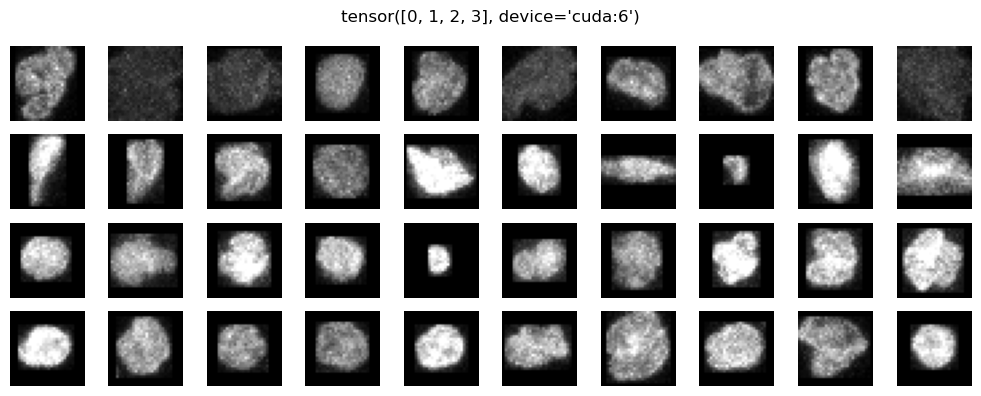

In [15]:
bag, lab = next(group_bagloader(bag_size=10))
fig, axs = plt.subplots(4, 10, figsize=(10, 4))
for im, ax in zip(bag, axs.flatten()):
  ax.imshow(im.squeeze().cpu(), cmap='gray', vmax=1, vmin=0)
  ax.axis('off')
fig.suptitle(lab.unique())
fig.tight_layout()
fig.show()

In [13]:
def eval_model(name, loader, classes=5):
    model = MultiClassifier(classes=classes)
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, z = model(bag.to(device))
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

### Big model

iter: 199999; train loss: 0.81709027; train error: 0.30000001: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200000/200000 [09:11<00:00, 362.47it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_by_cell_mil_architecture_model.pt


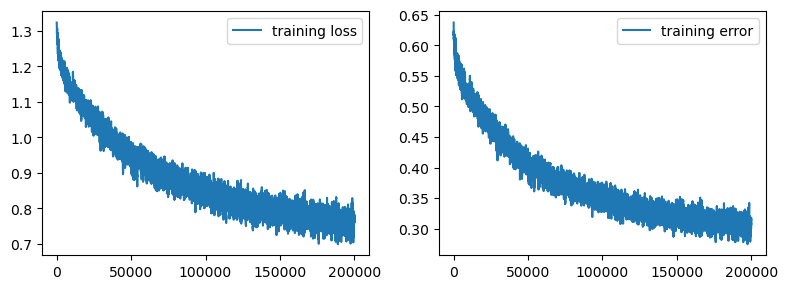

In [14]:
name = '3_12_t01_healthy_groups_by_cell_mil_architecture'
train_loader = group_bagloader()
model = MultiClassifier(classes=len(use_groups))
df = train_model(model, bag_loader=train_loader, num_iter=200_000, lr=0.001, device=device, fname=name, plot=False, 
                 save_model=True, seed=12341,
                 transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [16]:
dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('3_12_t01_healthy_groups_by_cell_mil_architecture', test_group_bagloader(use_plates=[plate]), classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)
res_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.89it/s]


lab  pred  i  pat                    group  plate
0        0     0  0  H06                  healthy      3
1        0     0  0  H06                  healthy      3
2        0     1  0  H06                  healthy      3
3        0     1  0  H06                  healthy      3
4        0     1  0  H06                  healthy      3
...    ...   ... ..  ...                      ...    ...
10895    3     3  6  P21  Chordoma/Chondrosarcoma     12
10896    3     2  6  P21  Chordoma/Chondrosarcoma     12
10897    3     1  6  P21  Chordoma/Chondrosarcoma     12
10898    3     3  6  P21  Chordoma/Chondrosarcoma     12
10899    3     3  6  P21  Chordoma/Chondrosarcoma     12

[10900 rows x 6 columns]

In [17]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df

plate   pat group pred  counts
0        3   H06     H    H      84
1        3   H06     H  H&N      11
2        3   H06     H    M       4
3        3   H06     H  C/C       1
4        3   H07     H    H     100
..     ...   ...   ...  ...     ...
389     12  P155   C/C  H&N      18
390     12   P21   C/C  C/C      43
391     12   P21   C/C    M      28
392     12   P21   C/C  H&N      26
393     12   P21   C/C    H       3

[394 rows x 5 columns]

/tmp/ipykernel_2588156/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_2588156/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_2588156/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_2588156

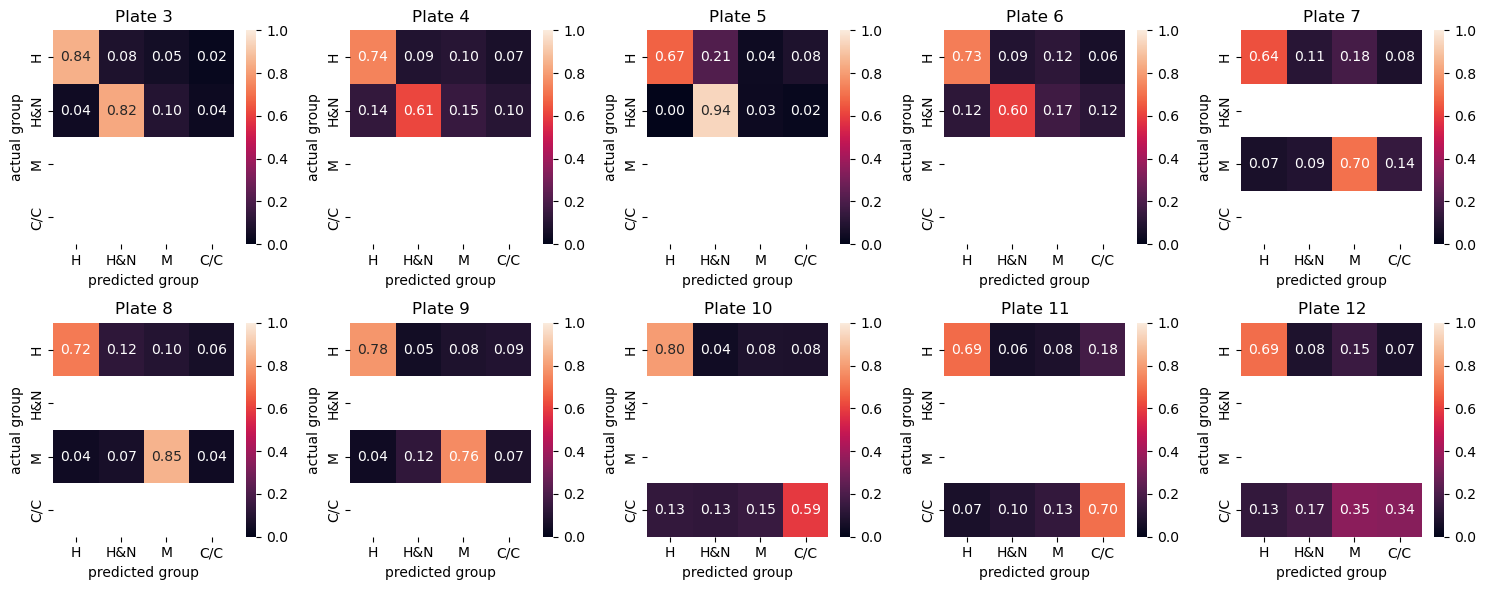

In [18]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

/tmp/ipykernel_2588156/1759129104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


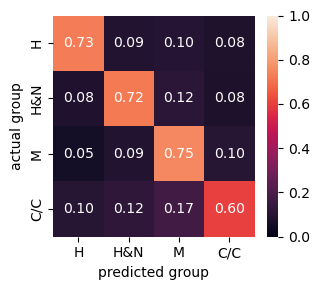

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/local_home/hschluet/anaconda3/envs/img-39/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


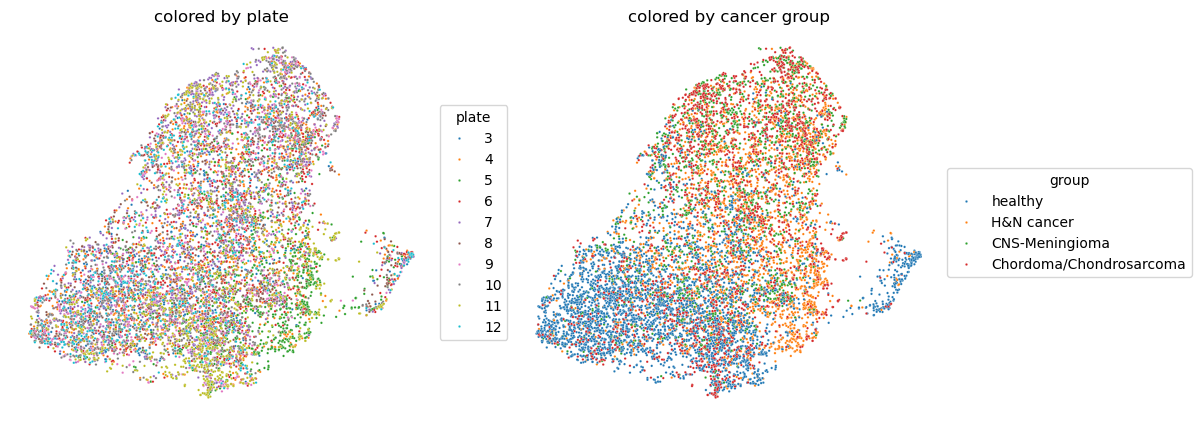

In [20]:
np.random.seed(1234)
vis_idx = np.random.choice(np.arange(len(res_df)), replace=False, size=10000)
res_df[['umap_x', 'umap_y']] = np.nan
res_df.loc[vis_idx, ['umap_x', 'umap_y']] = umap.UMAP(random_state=123).fit_transform(np.array(bag_zs)[vis_idx])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue='plate', s=3, ax=ax1, palette='tab10')
ax1.set_title('colored by plate')
sns.scatterplot(data=res_df, x='umap_x', y='umap_y', hue='group', s=3, ax=ax2, palette='tab10', hue_order=use_groups)
ax2.set_title('colored by cancer group')
for ax in (ax1, ax2,):
    sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off');

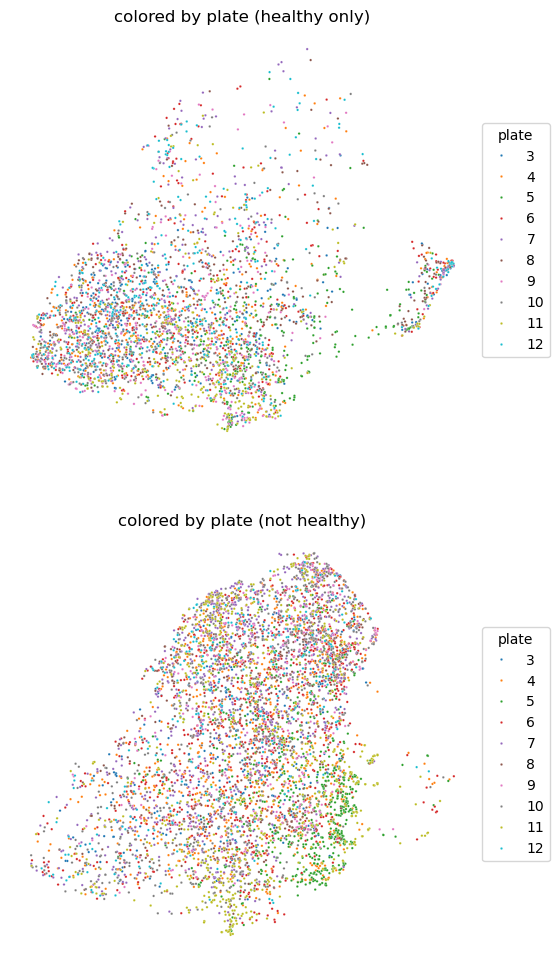

In [21]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))
sns.scatterplot(data=res_df[res_df['group'] == 'healthy'], x='umap_x', y='umap_y', hue='plate', s=3, ax=ax1, palette='tab10')
ax1.set_title('colored by plate (healthy only)')
sns.scatterplot(data=res_df[res_df['group'] != 'healthy'], x='umap_x', y='umap_y', hue='plate', s=3, ax=ax2, palette='tab10')
ax2.set_title('colored by plate (not healthy)')
for ax in (ax1, ax2,):
    sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off');

### Leave out one plate

  0%|                                                                                                                                                                                      | 0/100000 [00:00<?, ?it/s]

iter: 99999; train loss: 1.21959150; train error: 0.54500002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:58<00:00, 335.05it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_3_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.48733667; train error: 0.16500002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:00<00:00, 332.89it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_4_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.81223154; train error: 0.34000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:58<00:00, 334.86it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_5_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.53354120; train error: 0.21500003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:01<00:00, 331.19it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_6_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.62826729; train error: 0.29000002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:45<00:00, 350.86it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_7_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.83814502; train error: 0.37500000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:59<00:00, 334.24it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_8_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.81372803; train error: 0.35500002: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:52<00:00, 342.11it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_9_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.82955110; train error: 0.36500001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:56<00:00, 336.94it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_10_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.77736467; train error: 0.37500000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:58<00:00, 334.98it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_11_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.64757848; train error: 0.26500005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [05:04<00:00, 328.85it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_without_plate_12_by_cell_mil_architecture_model.pt


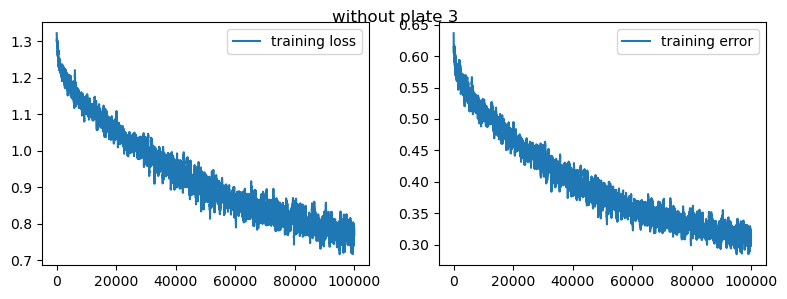

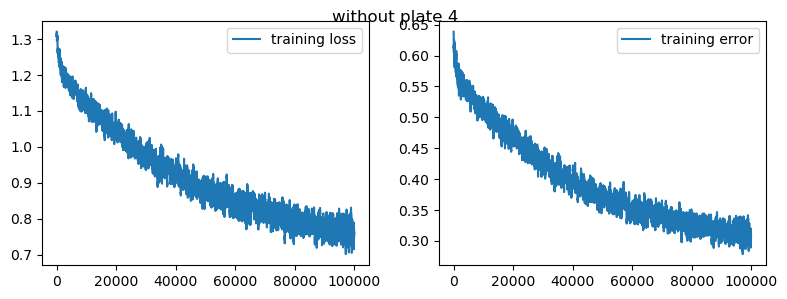

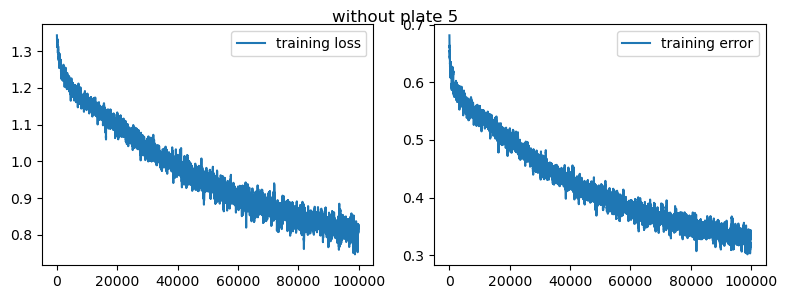

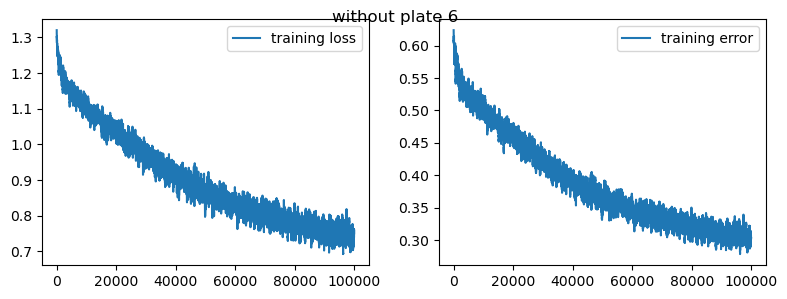

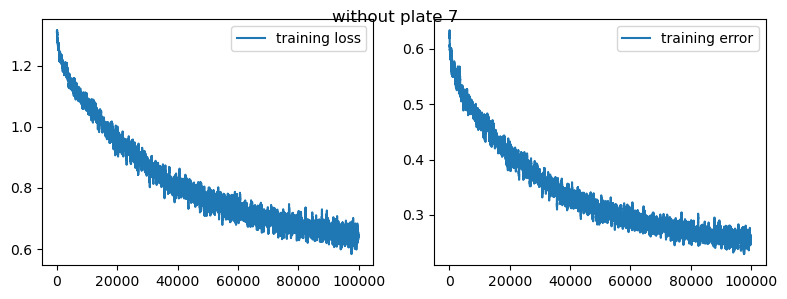

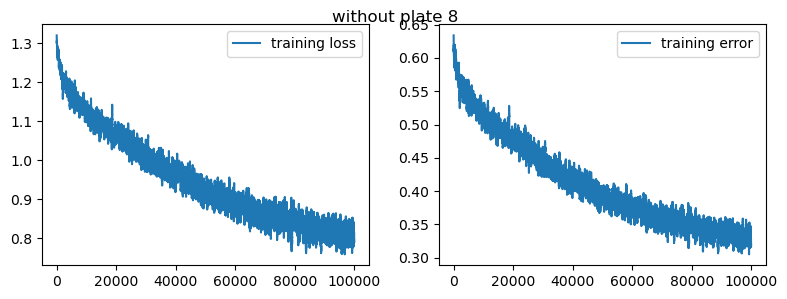

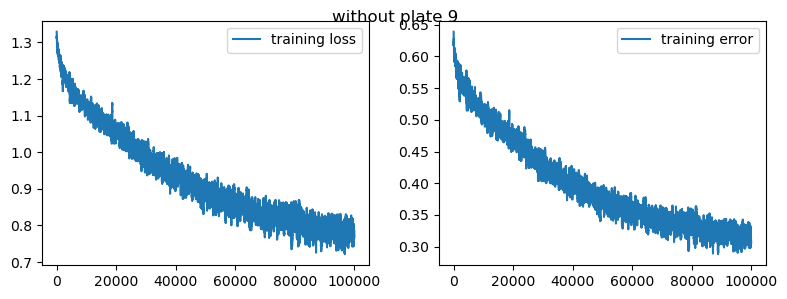

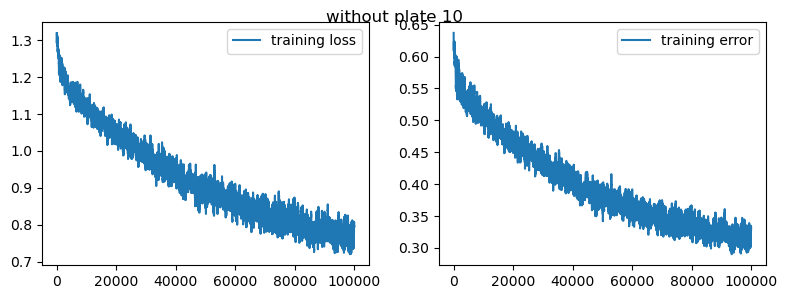

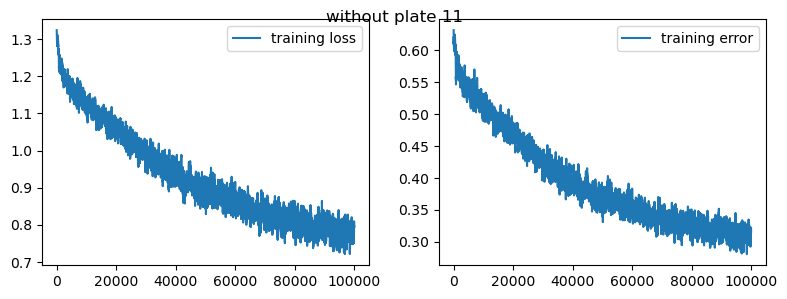

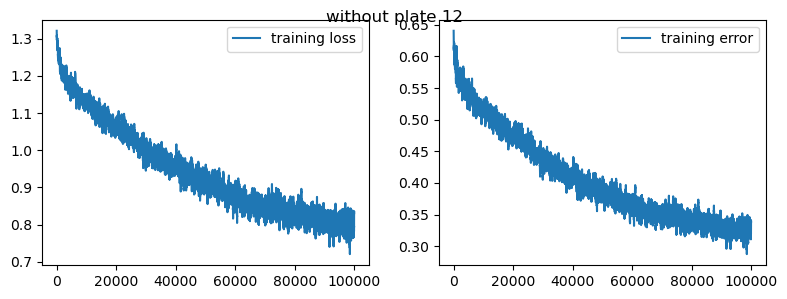

In [22]:
for plate in use_plates:
    name = f'3_12_t01_healthy_groups_without_plate_{plate}_by_cell_mil_architecture'
    train_loader = group_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = MultiClassifier(classes=len(use_groups))
    df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.001, device=device, fname=name, plot=False, 
                    save_model=True, seed=12341,
                    transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

In [23]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'3_12_t01_healthy_groups_without_plate_{plate}_by_cell_mil_architecture', 
                        test_group_bagloader(use_plates=[plate]), classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

 10%|█████████████████▊                                                                                                                                                                | 1/10 [00:00<00:01,  6.12it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.69it/s]


lab  pred  i  pat                    group  plate
0        0     0  0  H06                  healthy      3
1        0     1  0  H06                  healthy      3
2        0     1  0  H06                  healthy      3
3        0     0  0  H06                  healthy      3
4        0     0  0  H06                  healthy      3
...    ...   ... ..  ...                      ...    ...
10895    3     1  6  P21  Chordoma/Chondrosarcoma     12
10896    3     3  6  P21  Chordoma/Chondrosarcoma     12
10897    3     1  6  P21  Chordoma/Chondrosarcoma     12
10898    3     1  6  P21  Chordoma/Chondrosarcoma     12
10899    3     1  6  P21  Chordoma/Chondrosarcoma     12

[10900 rows x 6 columns]

In [24]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df

plate   pat group pred  counts
0        3   H06     H    H      71
1        3   H06     H  H&N      14
2        3   H06     H  C/C       8
3        3   H06     H    M       7
4        3   H07     H    H      66
..     ...   ...   ...  ...     ...
428     12  P155   C/C  C/C      19
429     12   P21   C/C  H&N      35
430     12   P21   C/C    M      32
431     12   P21   C/C  C/C      26
432     12   P21   C/C    H       7

[433 rows x 5 columns]

/tmp/ipykernel_2588156/1620754607.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_2588156/1620754607.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_2588156/1620754607.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_2588156

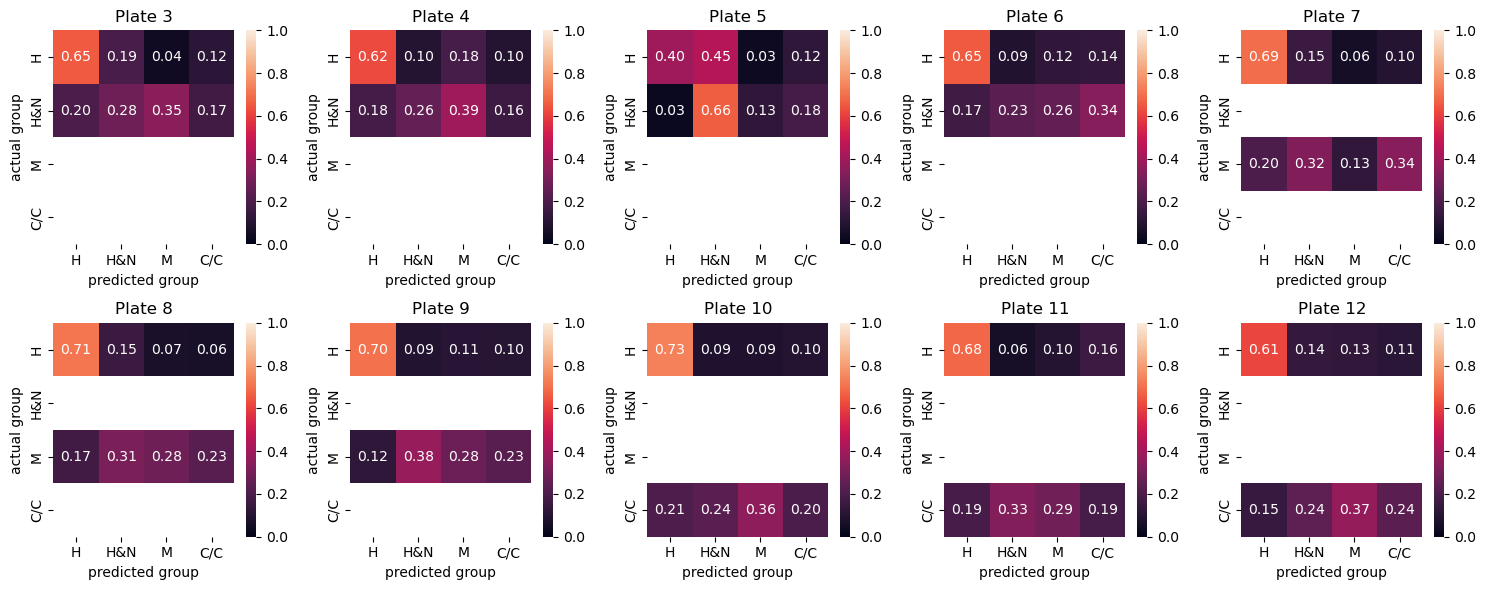

In [25]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = bag_df.reset_index()[bag_df.reset_index()['plate'] == plate].groupby(
    #     ['group', 'pred'])['i'].count().reset_index().pivot(index='group', columns='pred', values='i')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

/tmp/ipykernel_2588156/1759129104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


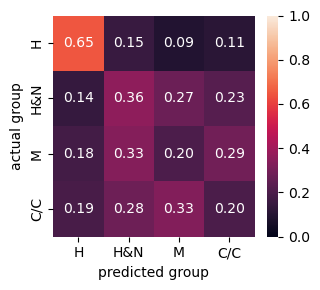

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

## Classification cancer T1 and healthy

In [26]:
data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  4.87it/s]


In [27]:
use_plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
cdf = data.info[data.info['plate'].isin(use_plates)].groupby(
    ['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H09', 'H10',
       'H13', 'H15', 'H16', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
       'H24', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36',
       'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48', 'H49', 'P102',
       'P103', 'P104', 'P105', 'P106', 'P107', 'P109', 'P11', 'P110',
       'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P117', 'P118',
       'P119', 'P120', 'P121', 'P123', 'P124', 'P125', 'P126', 'P127',
       'P128', 'P129', 'P13', 'P130', 'P131', 'P132', 'P134', 'P135',
       'P136', 'P137', 'P138', 'P139', 'P14', 'P140', 'P142', 'P143',
       'P144', 'P145', 'P146', 'P147', 'P148', 'P149', 'P15', 'P150',
       'P151', 'P152', 'P154', 'P155', 'P156', 'P158', 'P159', 'P16',
       'P160', 'P161', 'P162', 'P163', 'P164', 'P165', 'P166', 'P167',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P27', 'P28', 'P29', 'P30', 'P32', 'P33', 'P34', 'P35', 'P37',
       'P38', 'P

In [28]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma               7
CNS-Glioma                  17
CNS-Medulloblastoma          7
CNS-Meningioma              19
CNS-other                   12
Chordoma/Chondrosarcoma     21
H&N cancer                  37
Lymphoma                     7
Sarcoma-Ewing                8
Sarcoma-Neuroblastoma        2
Sarcoma-Rhabdomyosarcoma     4
Sarcoma-other                3
healthy                     35
Name: patient, dtype: int64

In [29]:
use_plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


def healthy_vs_cancer_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, 
                                transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['time'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_healthy = pat_groups[0]
  pat_cancer = pat_groups[1]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  pat_min = min(len(pat_healthy), len(pat_cancer))
  while True:
    xs = []
    labels = []
    for lab, pats in zip([0, 1], [pat_cancer, pat_healthy]):
      sub = np.random.choice(pats, size=pat_min, replace=False)
      for pat in sub:
        xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
        labels.append(lab * torch.ones(bag_size))
    
    labels = torch.cat(labels).float().to(device) 
    xs = torch.cat(xs).float()
    # shuffle indices
    rand_idx = torch.randperm(len(xs))
    for left in range(0, bag_size * 2 * pat_min, bag_size):
      yield xs[rand_idx[left:left+bag_size]], labels[rand_idx[left:left+bag_size]]


def test_healthy_vs_cancer_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_imgs = transform(data.imgs[use_idx].to(device))
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    idx = torch_random_choice(pat_idx, size=bag_size)
    label = 1 if pat[0] == 'H' else 0
    yield use_imgs[idx].float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'

In [30]:
from models import Classifier


def eval_model(name, loader):
    model = Classifier()
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, z = model(bag.to(device))
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

In [31]:
xs, labs = next(healthy_vs_cancer_bagloader())
labs

tensor([0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0.],
       device='cuda:6')

### Big model

iter: 99999; train loss: 0.56302965; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:07<00:00, 403.82it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_by_cell_mil_architecture_model.pt


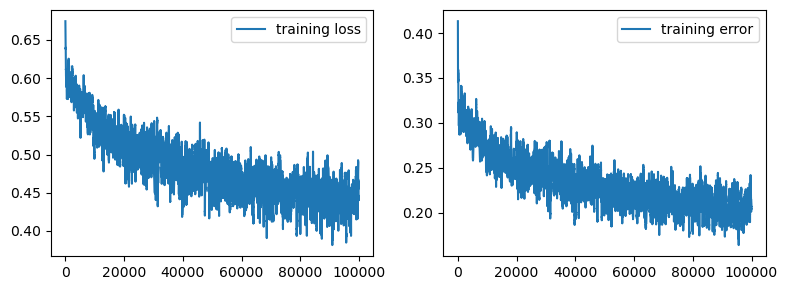

In [33]:
name = '1_16_t01_healthy_cancer_by_cell_mil_architecture'
train_loader = healthy_vs_cancer_bagloader()
model = Classifier()
df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                 save_model=True, seed=12341,
                 transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [34]:
dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('1_16_t01_healthy_cancer_by_cell_mil_architecture', 
                         test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)
res_df

  0%|                                                                                                                                                                                          | 0/16 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.96it/s]


lab  pred   i  pat    group  plate
0        1   1.0   0  H01  healthy      1
1        1   1.0   0  H01  healthy      1
2        1   1.0   0  H01  healthy      1
3        1   0.0   0  H01  healthy      1
4        1   1.0   0  H01  healthy      1
...    ...   ...  ..  ...      ...    ...
20195    0   0.0  11  P74   cancer     16
20196    0   0.0  11  P74   cancer     16
20197    0   1.0  11  P74   cancer     16
20198    0   0.0  11  P74   cancer     16
20199    0   0.0  11  P74   cancer     16

[20200 rows x 6 columns]

In [35]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df

plate  pat    group  pred  counts
0        1  H01  healthy   1.0      77
1        1  H01  healthy   0.0      23
2        1  H02  healthy   1.0      91
3        1  H02  healthy   0.0       9
4        1  H03  healthy   1.0      91
..     ...  ...      ...   ...     ...
391     16  P45   cancer   1.0      39
392     16  P61   cancer   0.0      54
393     16  P61   cancer   1.0      46
394     16  P74   cancer   0.0      73
395     16  P74   cancer   1.0      27

[396 rows x 5 columns]

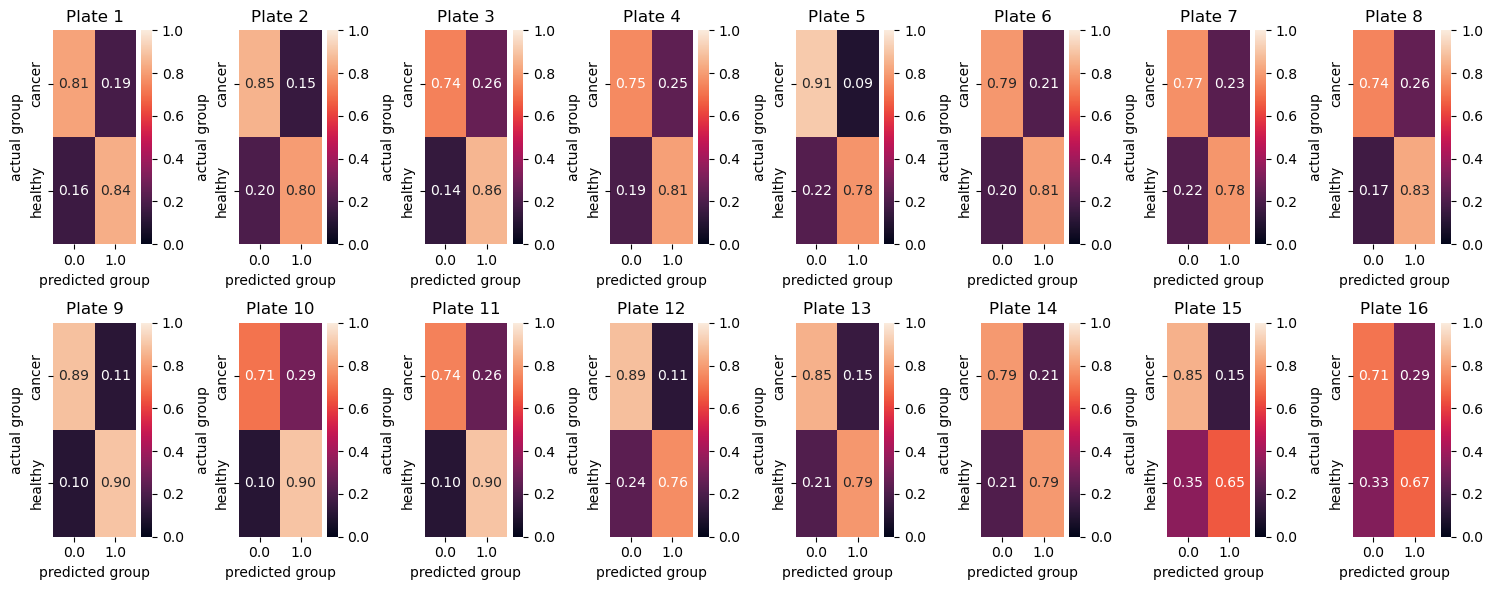

In [36]:
fig, axs = plt.subplots(2, 8, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = bag_df.reset_index()[bag_df.reset_index()['plate'] == plate].groupby(
    #     ['group', 'pred'])['i'].count().reset_index().pivot(index='group', columns='pred', values='i')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

# pat_df['healthy'] = pat_df['healthy'].replace({True : 'H', False : 'C'})
# fig, axs = plt.subplots(2, 7, figsize=(10, 4), sharex=True, sharey=True)
# for ax, plate in zip(axs.flatten(), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]):
#     mat = pat_df[pat_df['plate'] == str(plate)].groupby('healthy')[['pred C %', 'pred H %']].mean(
#     ).rename(columns={'pred C %' : 'C', 'pred H %' : 'H'}).loc[['H', 'C'], ['H', 'C']]
#     sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
#     ax.set_ylabel('')
#     ax.set_xlabel('')
#     ax.set_title(f'Plate {plate}')
# fig.tight_layout()

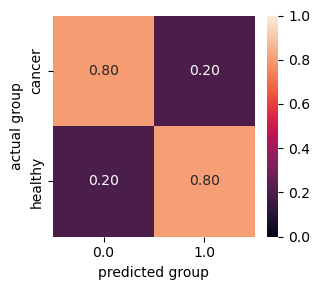

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

### Leave out one plate

iter: 99999; train loss: 0.40836516; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:47<00:00, 348.01it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_1_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.39650503; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:40<00:00, 356.57it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_2_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.41197607; train error: 0.28000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:24<00:00, 377.37it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_3_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.38379872; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:43<00:00, 352.32it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_4_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.55682105; train error: 0.31999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:45<00:00, 349.99it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_5_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.44106483; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:34<00:00, 364.30it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_6_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.43221247; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:32<00:00, 366.96it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_7_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.47422799; train error: 0.25999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:46<00:00, 349.31it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_8_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.42581642; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:32<00:00, 366.59it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_9_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.39667106; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:48<00:00, 346.32it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_10_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.39279455; train error: 0.12000000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:27<00:00, 374.46it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_11_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.49264967; train error: 0.28000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:36<00:00, 361.16it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_12_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.35579696; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:50<00:00, 344.61it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_13_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.40079445; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:37<00:00, 359.94it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_14_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.43072060; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:37<00:00, 360.98it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_15_by_cell_mil_architecture_model.pt


iter: 99999; train loss: 0.56806993; train error: 0.30000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [04:43<00:00, 352.27it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_17_t01_healthy_cancer_without_plate_16_by_cell_mil_architecture_model.pt


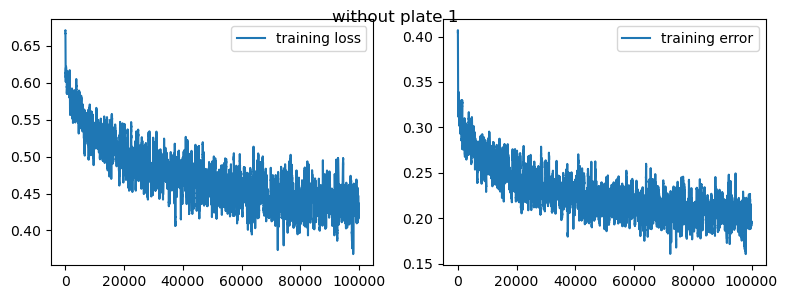

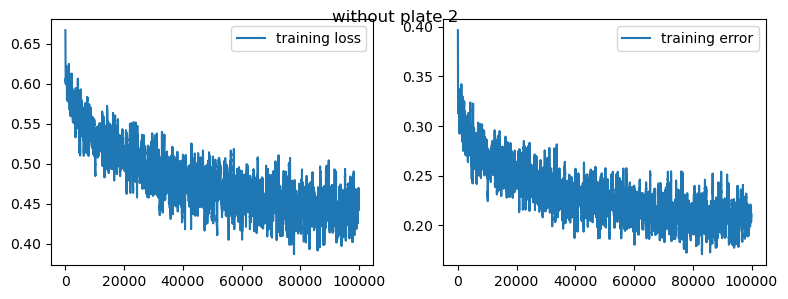

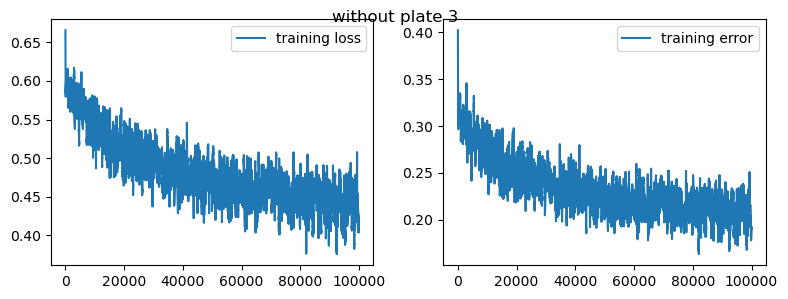

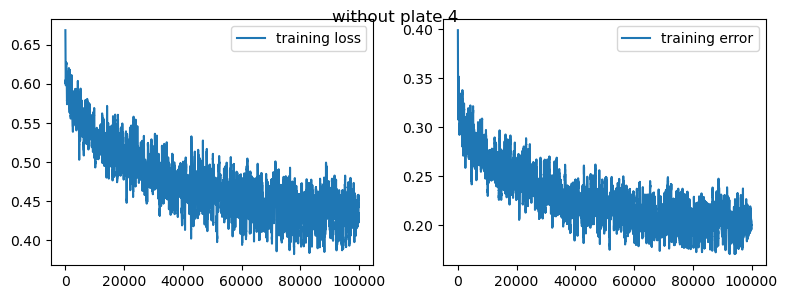

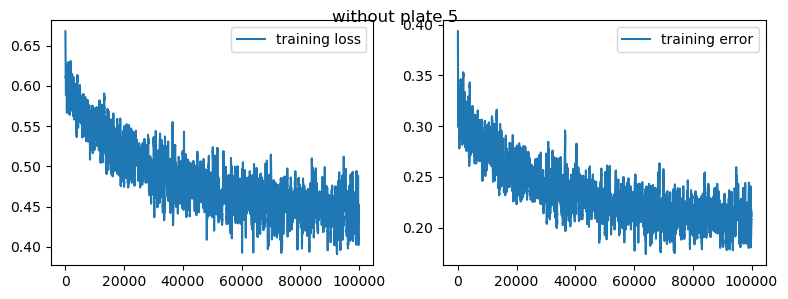

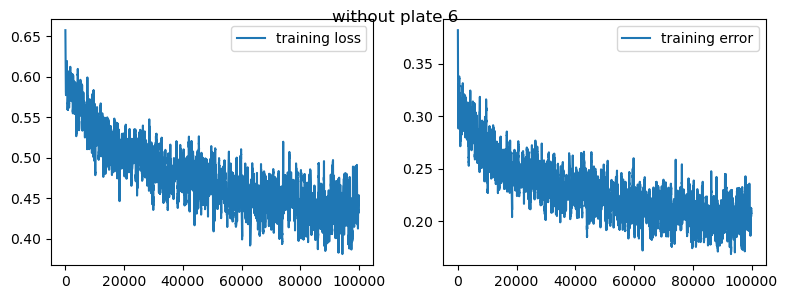

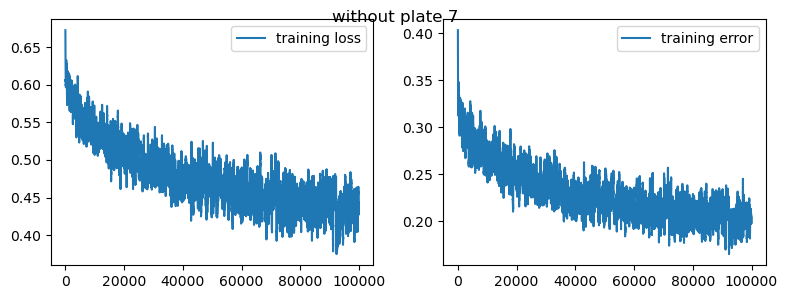

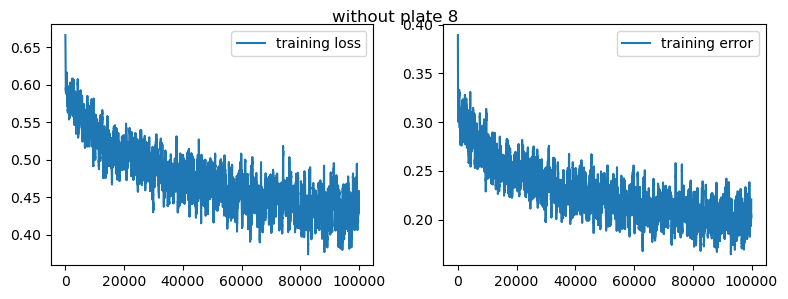

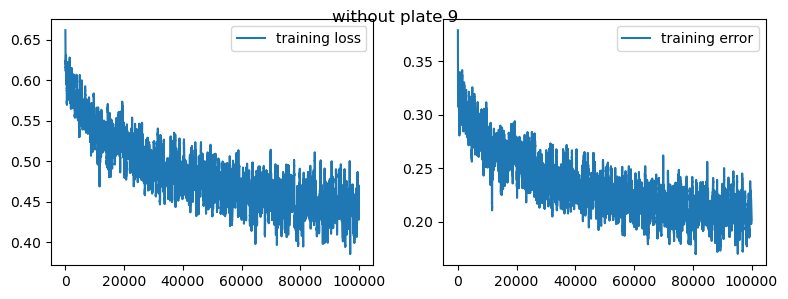

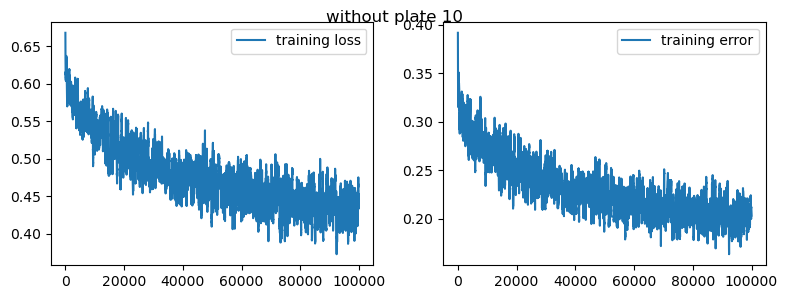

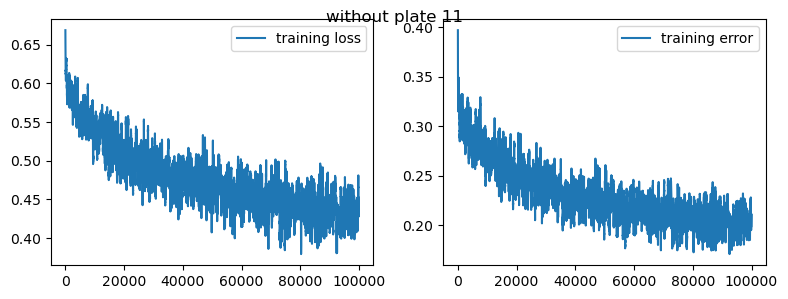

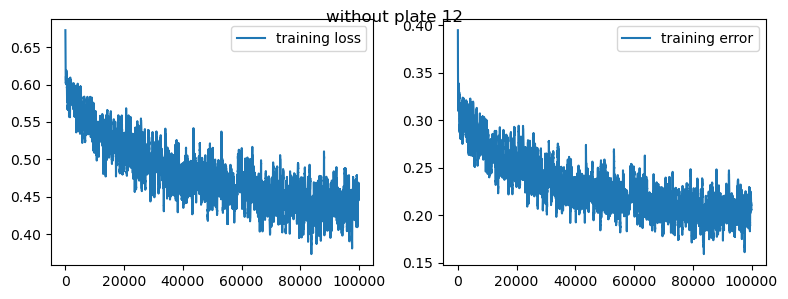

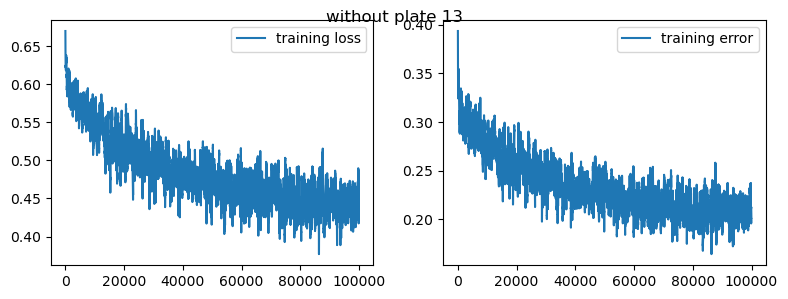

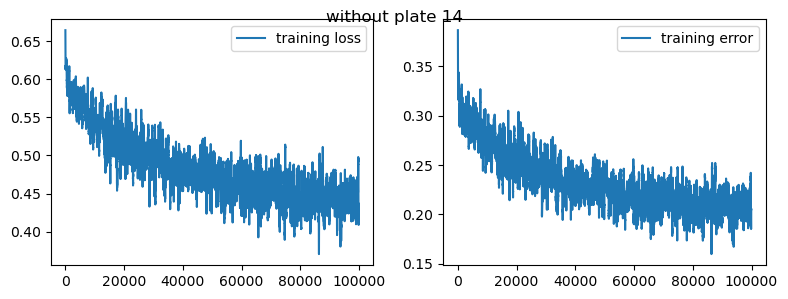

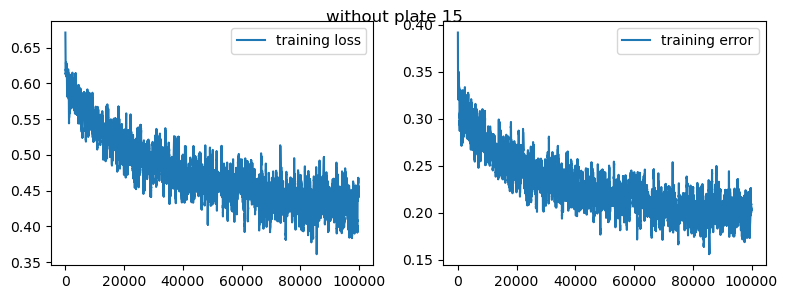

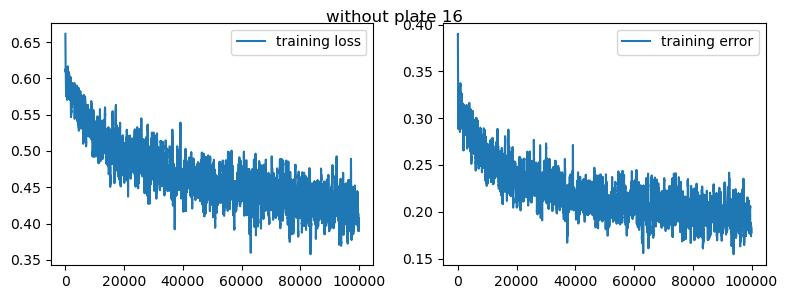

In [ ]:
for plate in use_plates:
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_mil_architecture'
    train_loader = healthy_vs_cancer_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = Classifier()
    df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                     save_model=True, seed=12341,
                     transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

# file names are wrong in output due to typo (should be 1_16 not 1_17 for plates used)

In [ ]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'1_17_t01_healthy_cancer_without_plate_{plate}_by_cell_mil_architecture', 
                        test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.15it/s]


lab  pred   i  pat    group  plate
0        1   1.0   0  H01  healthy      1
1        1   1.0   0  H01  healthy      1
2        1   1.0   0  H01  healthy      1
3        1   1.0   0  H01  healthy      1
4        1   1.0   0  H01  healthy      1
...    ...   ...  ..  ...      ...    ...
20195    0   0.0  11  P74   cancer     16
20196    0   0.0  11  P74   cancer     16
20197    0   0.0  11  P74   cancer     16
20198    0   0.0  11  P74   cancer     16
20199    0   0.0  11  P74   cancer     16

[20200 rows x 6 columns]

In [ ]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
# pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C', 'G'])
# pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C', 'G'])
pat_df

plate   pat    group  pred  counts
0        1   H01  healthy   1.0      57
1        1   H01  healthy   0.0      43
2        1   H02  healthy   1.0      73
3        1   H02  healthy   0.0      27
4        1   H03  healthy   1.0      64
..     ...   ...      ...   ...     ...
374     16  P151   cancer   0.0      99
375     16  P151   cancer   1.0       1
376     16   P45   cancer   0.0     100
377     16   P61   cancer   0.0     100
378     16   P74   cancer   0.0     100

[379 rows x 5 columns]

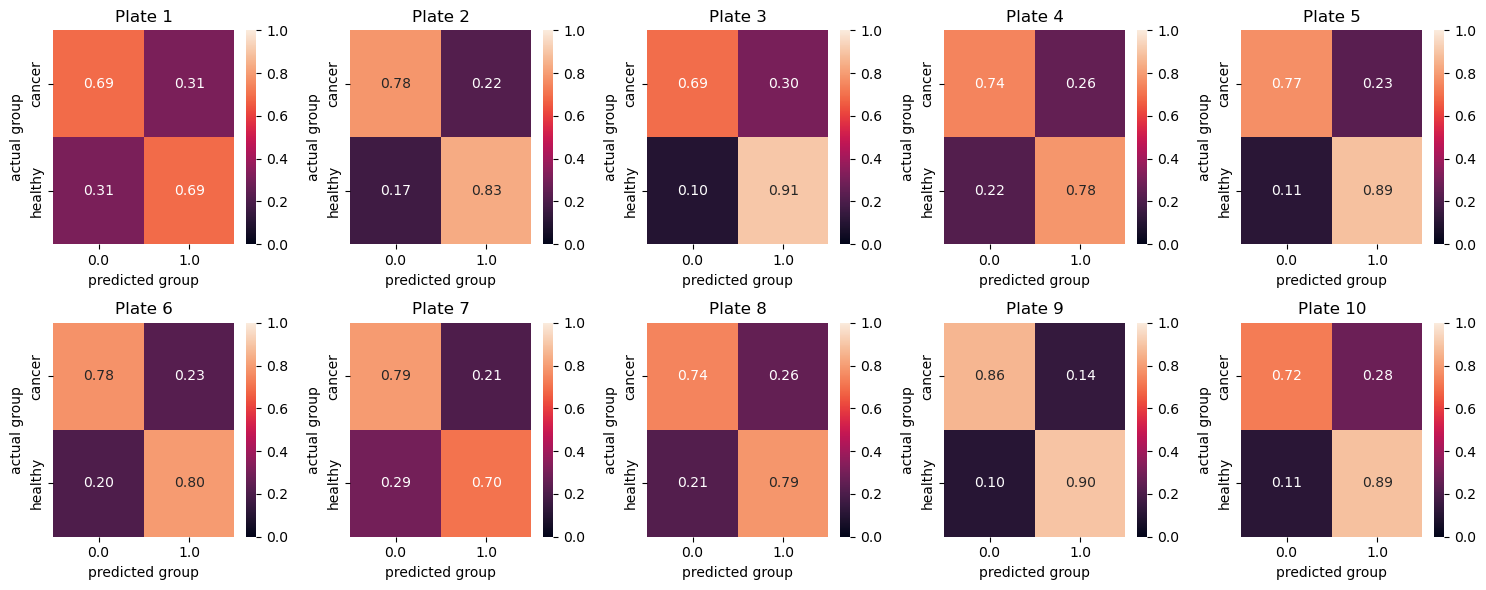

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = bag_df.reset_index()[bag_df.reset_index()['plate'] == plate].groupby(
    #     ['group', 'pred'])['i'].count().reset_index().pivot(index='group', columns='pred', values='i')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

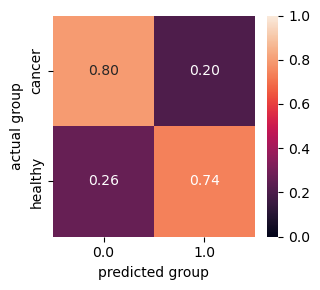

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

In [ ]:
res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()

plate   pat    group  pred
0        1   H01  healthy  0.57
1        1   H02  healthy  0.73
2        1   H03  healthy  0.64
3        1   H04  healthy  0.76
4        1   H05  healthy  0.75
..     ...   ...      ...   ...
197     16  P139   cancer  0.00
198     16  P151   cancer  0.01
199     16   P45   cancer  0.00
200     16   P61   cancer  0.00
201     16   P74   cancer  0.00

[202 rows x 4 columns]

In [ ]:
pat_df = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()
plate_df = pat_df.groupby(['plate', 'group'])['pred'].mean().reset_index()
plate_df.loc[plate_df['group'] != 'healthy', 'group'] = 'C'
plate_df.loc[plate_df['group'] == 'healthy', 'group'] = 'H'
plate_df['group'] = pd.Categorical(values=plate_df['group'], categories=['H', 'C'])
plate_df['H'] = plate_df['pred']
plate_df['C'] = 1 - plate_df['H']

# pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'C'
# pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'H'
# pat_df['group'] = pat_df['group'].replace({'healthy' : 'H', 'cancer' : 'C'})
# pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['H', 'C'])
# pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['H', 'C'])
# pat_df.set_index(['plate', 'pat', 'group'])

plate_df

plate group      pred         H         C
0       1     C  0.311429  0.311429  0.688571
1       1     H  0.690000  0.690000  0.310000
2       2     C  0.217778  0.217778  0.782222
3       2     H  0.832500  0.832500  0.167500
4       3     C  0.305000  0.305000  0.695000
5       3     H  0.905000  0.905000  0.095000
6       4     C  0.257778  0.257778  0.742222
7       4     H  0.782500  0.782500  0.217500
8       5     C  0.231250  0.231250  0.768750
9       5     H  0.887500  0.887500  0.112500
10      6     C  0.225000  0.225000  0.775000
11      6     H  0.795000  0.795000  0.205000
12      7     C  0.206667  0.206667  0.793333
13      7     H  0.705000  0.705000  0.295000
14      8     C  0.257000  0.257000  0.743000
15      8     H  0.785000  0.785000  0.215000
16      9     C  0.140000  0.140000  0.860000
17      9     H  0.895000  0.895000  0.105000
18     10     C  0.276667  0.276667  0.723333
19     10     H  0.887500  0.887500  0.112500
20     11     C  0.306667  0.306667  0.693333
21     11     H  0.890000  0.890000  0.110000
22     12     C  0.115000  0.115000  0.885000
23     12     H  0.780000  0.780000  0.220000
24     13     C  0.151111  0.151111  0.848889
25     13     H  0.787500  0.787500  0.212500
26     14     C  0.201111  0.201111  0.798889
27     14     H  0.770000  0.770000  0.230000
28     15     C  0.126000  0.126000  0.874000
29     15     H  0.390000  0.390000  0.610000
30     16     C  0.001250  0.001250  0.998750
31     16     H  0.002500  0.002500  0.997500

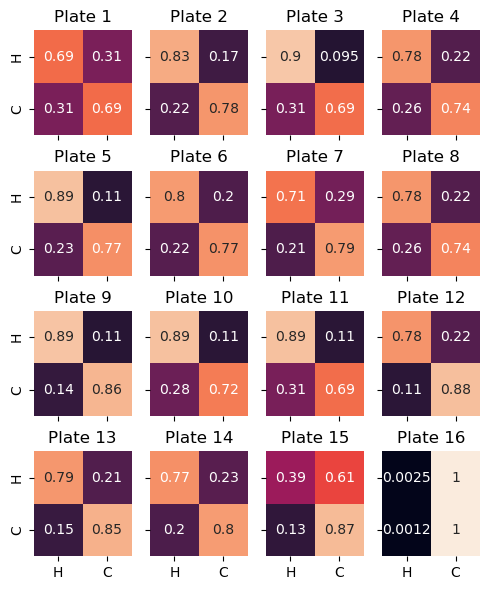

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = pat_df[pat_df['plate'] == plate].groupby(
    #     ['group', 'pred'])['pat'].count().reset_index().pivot(index='group', columns='pred', values='pat')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = plate_df[plate_df['plate'] == plate].set_index('group').loc[['H', 'C'], ['H', 'C']]
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

In [ ]:
print('done!')

done!


## Classification cancer T1 and healthy (masked cells)

In [52]:
data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], load_masks=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:39<00:00,  6.21s/it]


In [53]:
use_plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
cdf = data.info[data.info['plate'].isin(use_plates)].groupby(
    ['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H09', 'H10',
       'H13', 'H15', 'H16', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
       'H24', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36',
       'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48', 'H49', 'P102',
       'P103', 'P104', 'P105', 'P106', 'P107', 'P109', 'P11', 'P110',
       'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P117', 'P118',
       'P119', 'P120', 'P121', 'P123', 'P124', 'P125', 'P126', 'P127',
       'P128', 'P129', 'P13', 'P130', 'P131', 'P132', 'P134', 'P135',
       'P136', 'P137', 'P138', 'P139', 'P14', 'P140', 'P142', 'P143',
       'P144', 'P145', 'P146', 'P147', 'P148', 'P149', 'P15', 'P150',
       'P151', 'P152', 'P154', 'P155', 'P156', 'P158', 'P159', 'P16',
       'P160', 'P161', 'P162', 'P163', 'P164', 'P165', 'P166', 'P167',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P27', 'P28', 'P29', 'P30', 'P32', 'P33', 'P34', 'P35', 'P37',
       'P38', 'P

In [54]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma               7
CNS-Glioma                  17
CNS-Medulloblastoma          7
CNS-Meningioma              19
CNS-other                   12
Chordoma/Chondrosarcoma     21
H&N cancer                  37
Lymphoma                     7
Sarcoma-Ewing                8
Sarcoma-Neuroblastoma        2
Sarcoma-Rhabdomyosarcoma     4
Sarcoma-other                3
healthy                     35
Name: patient, dtype: int64

In [55]:
use_plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


def healthy_vs_cancer_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, 
                                transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform((data.imgs[use_idx] * data.masks[use_idx]).to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['time'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_healthy = pat_groups[0]
  pat_cancer = pat_groups[1]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  pat_min = min(len(pat_healthy), len(pat_cancer))
  while True:
    xs = []
    labels = []
    for lab, pats in zip([0, 1], [pat_cancer, pat_healthy]):
      sub = np.random.choice(pats, size=pat_min, replace=False)
      for pat in sub:
        xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
        labels.append(lab * torch.ones(bag_size))
    
    labels = torch.cat(labels).float().to(device) 
    xs = torch.cat(xs).float()
    # shuffle indices
    rand_idx = torch.randperm(len(xs))
    for left in range(0, bag_size * 2 * pat_min, bag_size):
      yield xs[rand_idx[left:left+bag_size]], labels[rand_idx[left:left+bag_size]]


def test_healthy_vs_cancer_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_imgs = transform((data.imgs[use_idx] * data.masks[use_idx]).to(device))
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    idx = torch_random_choice(pat_idx, size=bag_size)
    label = 1 if pat[0] == 'H' else 0
    yield use_imgs[idx].float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'

In [56]:
from models import Classifier


def eval_model(name, loader):
    model = Classifier()
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, z = model(bag.to(device))
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

In [57]:
xs, labs = next(healthy_vs_cancer_bagloader())
labs

tensor([0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0.],
       device='cuda:3')

### Leave out one plate

iter: 99999; train loss: 0.43658790; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:59<00:00, 208.60it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_1_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.37867659; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [08:11<00:00, 203.65it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_2_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.48490280; train error: 0.28000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [08:09<00:00, 204.23it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_3_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.33963722; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:37<00:00, 218.40it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_4_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.56694639; train error: 0.30000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:49<00:00, 213.15it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_5_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.47517976; train error: 0.25999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:42<00:00, 216.11it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_6_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.36893156; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:31<00:00, 221.70it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_7_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.52676153; train error: 0.30000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:31<00:00, 221.33it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_8_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.40895644; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:31<00:00, 221.62it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_9_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.45802665; train error: 0.30000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:31<00:00, 221.39it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_10_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.41781524; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:13<00:00, 230.69it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_11_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.53614932; train error: 0.28000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:08<00:00, 233.36it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_12_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.40610245; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:13<00:00, 230.50it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_13_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.47268519; train error: 0.28000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:55<00:00, 240.52it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_14_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.52207822; train error: 0.25999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:48<00:00, 244.89it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_15_by_cell_mil_architecture_masked_model.pt


iter: 99999; train loss: 0.55318701; train error: 0.30000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:19<00:00, 263.31it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_16_by_cell_mil_architecture_masked_model.pt


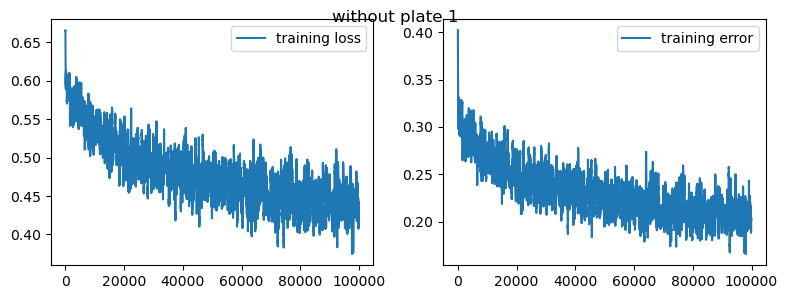

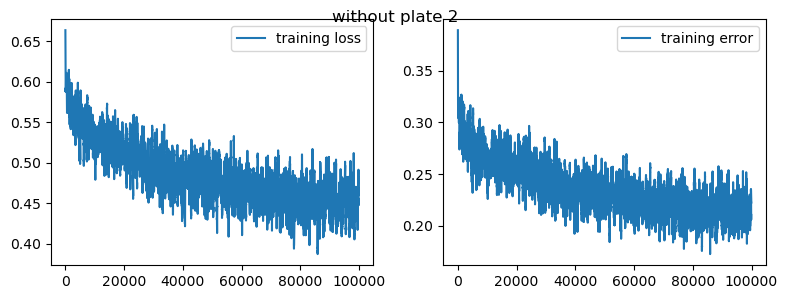

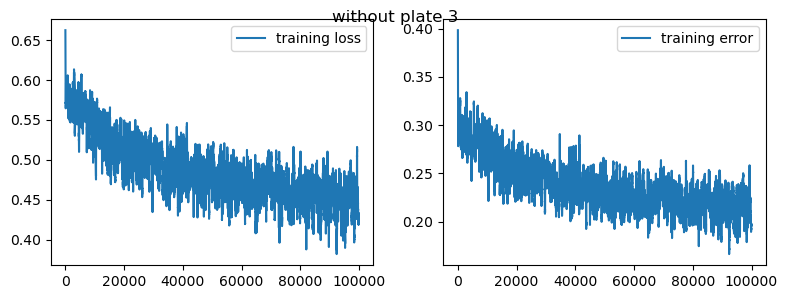

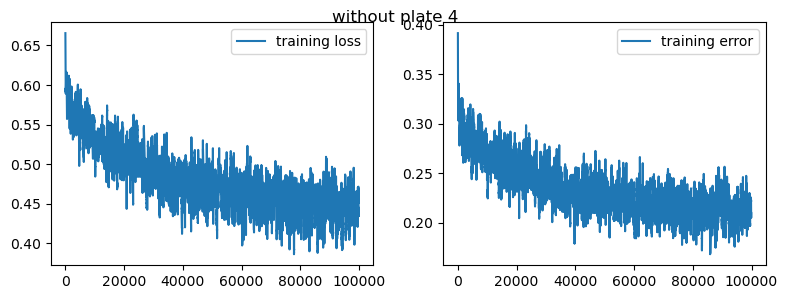

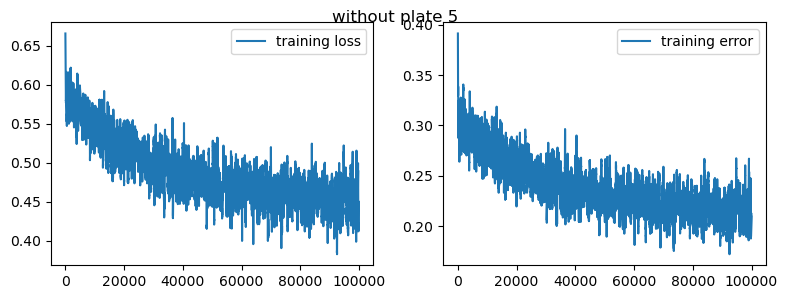

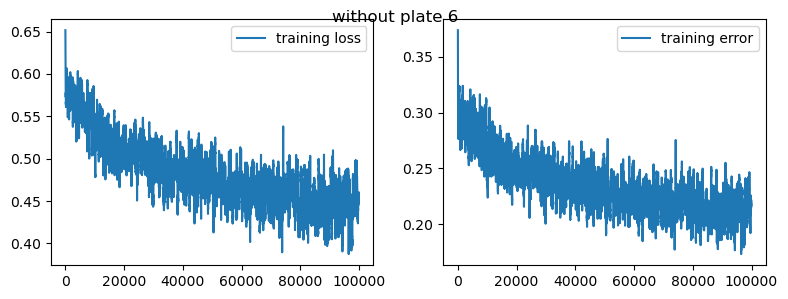

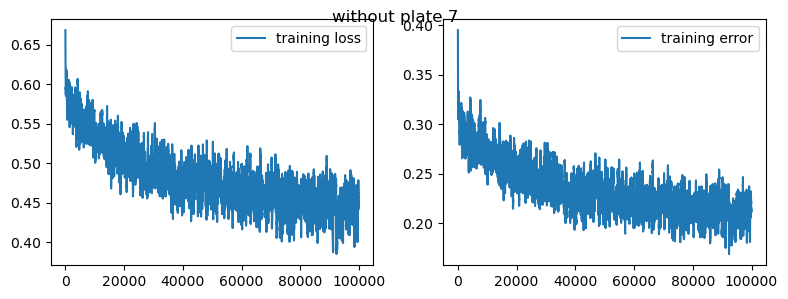

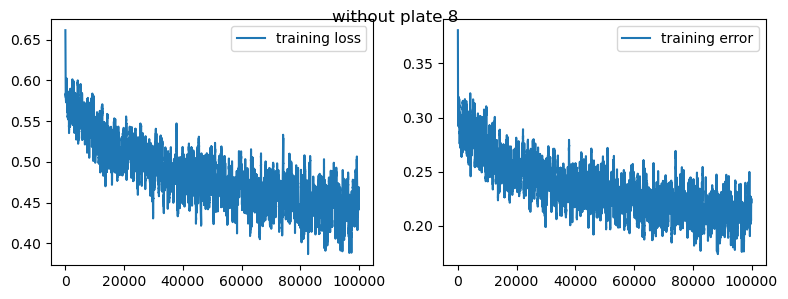

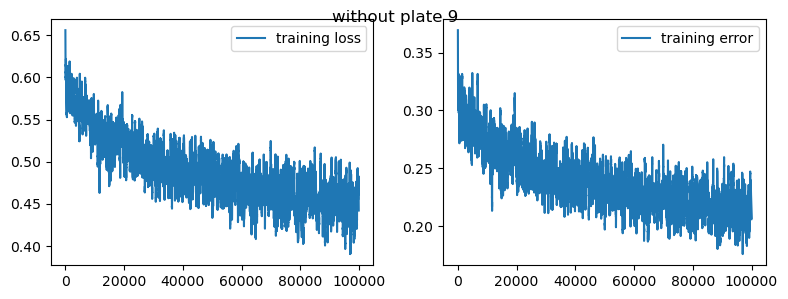

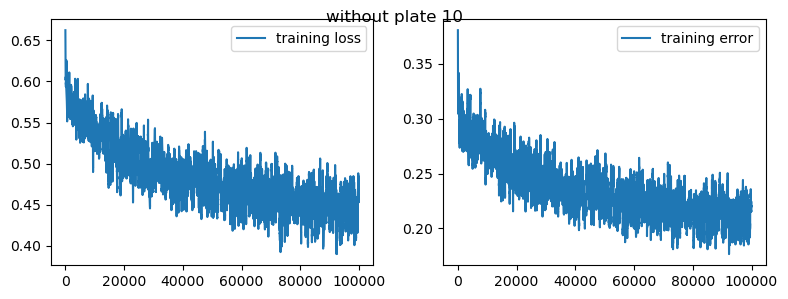

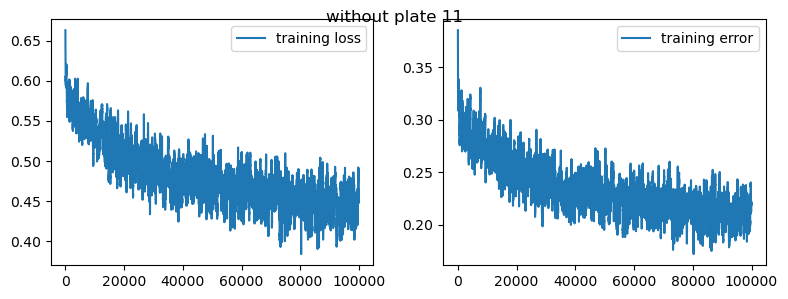

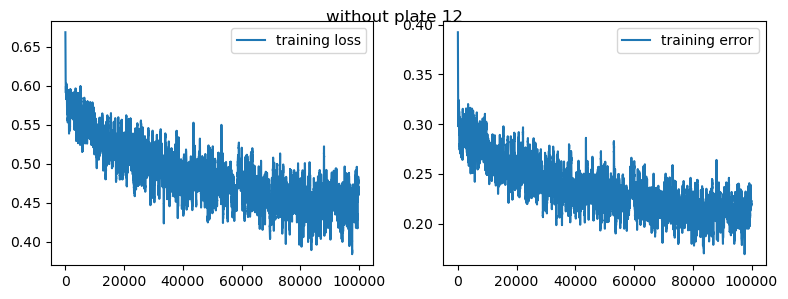

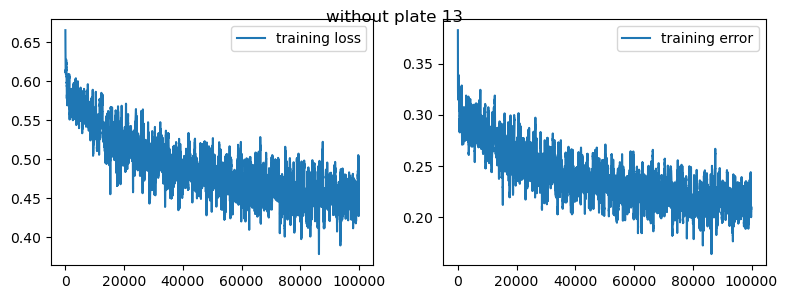

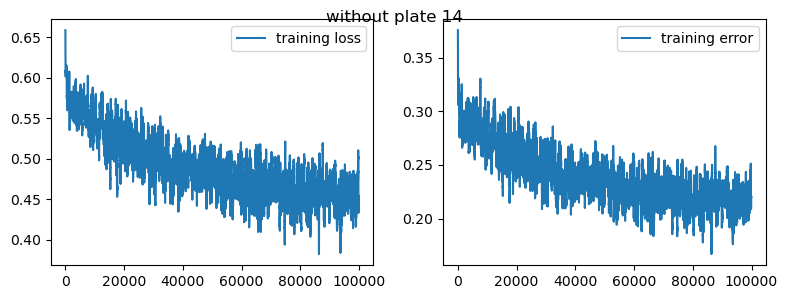

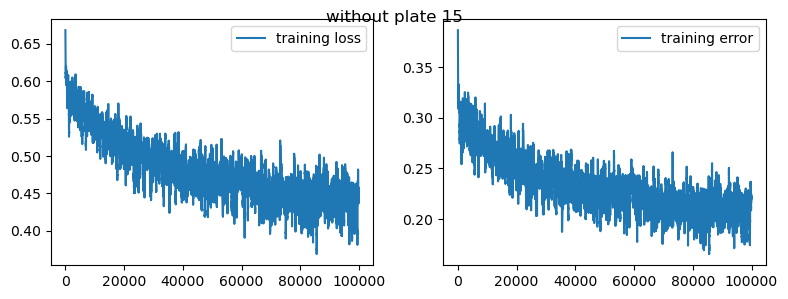

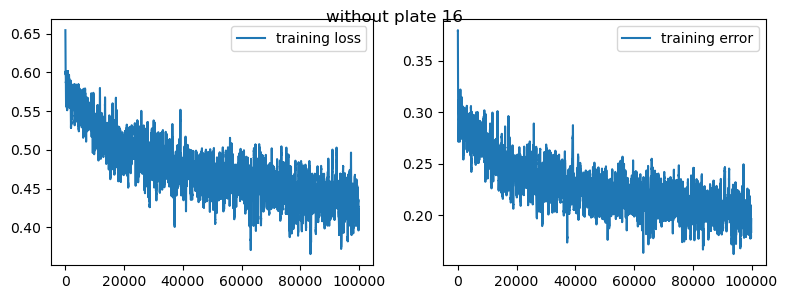

In [58]:
for plate in use_plates:
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_mil_architecture_masked'
    train_loader = healthy_vs_cancer_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = Classifier()
    df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                     save_model=True, seed=12341,
                     transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

In [60]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_mil_architecture_masked', 
                        test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

  0%|                                                                                                                                                                                          | 0/16 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.85it/s]


lab  pred   i  pat    group  plate
0        1   1.0   0  H01  healthy      1
1        1   1.0   0  H01  healthy      1
2        1   1.0   0  H01  healthy      1
3        1   1.0   0  H01  healthy      1
4        1   0.0   0  H01  healthy      1
...    ...   ...  ..  ...      ...    ...
20195    0   1.0  11  P74   cancer     16
20196    0   0.0  11  P74   cancer     16
20197    0   0.0  11  P74   cancer     16
20198    0   0.0  11  P74   cancer     16
20199    0   0.0  11  P74   cancer     16

[20200 rows x 6 columns]

In [61]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
# pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C', 'G'])
# pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C', 'G'])
pat_df

plate  pat    group  pred  counts
0        1  H01  healthy   1.0      63
1        1  H01  healthy   0.0      37
2        1  H02  healthy   1.0      85
3        1  H02  healthy   0.0      15
4        1  H03  healthy   1.0      54
..     ...  ...      ...   ...     ...
393     16  P45   cancer   1.0      23
394     16  P61   cancer   0.0      85
395     16  P61   cancer   1.0      15
396     16  P74   cancer   0.0      84
397     16  P74   cancer   1.0      16

[398 rows x 5 columns]

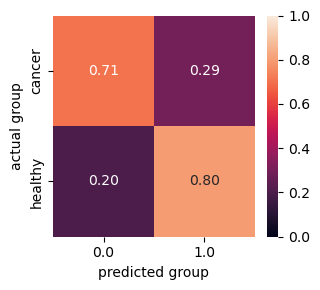

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

In [63]:
res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()

plate   pat    group  pred
0        1   H01  healthy  0.63
1        1   H02  healthy  0.85
2        1   H03  healthy  0.54
3        1   H04  healthy  0.80
4        1   H05  healthy  0.77
..     ...   ...      ...   ...
197     16  P139   cancer  0.27
198     16  P151   cancer  0.13
199     16   P45   cancer  0.23
200     16   P61   cancer  0.15
201     16   P74   cancer  0.16

[202 rows x 4 columns]

In [64]:
pat_df = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()
plate_df = pat_df.groupby(['plate', 'group'])['pred'].mean().reset_index()
plate_df.loc[plate_df['group'] != 'healthy', 'group'] = 'C'
plate_df.loc[plate_df['group'] == 'healthy', 'group'] = 'H'
plate_df['group'] = pd.Categorical(values=plate_df['group'], categories=['H', 'C'])
plate_df['H'] = plate_df['pred']
plate_df['C'] = 1 - plate_df['H']

# pat_df.loc[pat_df['pred'] == 0, 'pred_group'] = 'C'
# pat_df.loc[pat_df['pred'] == 1, 'pred_group'] = 'H'
# pat_df['group'] = pat_df['group'].replace({'healthy' : 'H', 'cancer' : 'C'})
# pat_df['group'] = pd.Categorical(values=pat_df['group'], categories=['H', 'C'])
# pat_df['pred_group'] = pd.Categorical(values=pat_df['pred_group'], categories=['H', 'C'])
# pat_df.set_index(['plate', 'pat', 'group'])

plate_df

plate group      pred         H         C
0       1     C  0.514286  0.514286  0.485714
1       1     H  0.718000  0.718000  0.282000
2       2     C  0.306667  0.306667  0.693333
3       2     H  0.855000  0.855000  0.145000
4       3     C  0.397500  0.397500  0.602500
5       3     H  0.882500  0.882500  0.117500
6       4     C  0.373333  0.373333  0.626667
7       4     H  0.877500  0.877500  0.122500
8       5     C  0.395000  0.395000  0.605000
9       5     H  0.922500  0.922500  0.077500
10      6     C  0.312000  0.312000  0.688000
11      6     H  0.857500  0.857500  0.142500
12      7     C  0.276667  0.276667  0.723333
13      7     H  0.787500  0.787500  0.212500
14      8     C  0.308000  0.308000  0.692000
15      8     H  0.810000  0.810000  0.190000
16      9     C  0.214286  0.214286  0.785714
17      9     H  0.945000  0.945000  0.055000
18     10     C  0.314444  0.314444  0.685556
19     10     H  0.930000  0.930000  0.070000
20     11     C  0.348889  0.348889  0.651111
21     11     H  0.950000  0.950000  0.050000
22     12     C  0.186000  0.186000  0.814000
23     12     H  0.877500  0.877500  0.122500
24     13     C  0.228889  0.228889  0.771111
25     13     H  0.885000  0.885000  0.115000
26     14     C  0.320000  0.320000  0.680000
27     14     H  0.840000  0.840000  0.160000
28     15     C  0.152000  0.152000  0.848000
29     15     H  0.375000  0.375000  0.625000
30     16     C  0.153750  0.153750  0.846250
31     16     H  0.297500  0.297500  0.702500

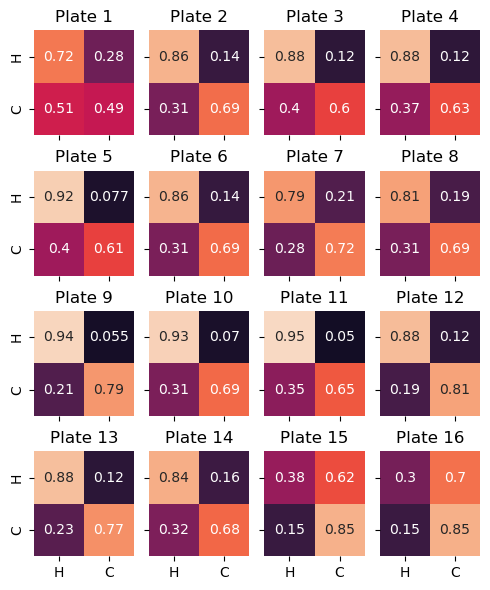

In [65]:
fig, axs = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
for ax, plate in zip(axs.flatten(), use_plates):
    # mat = pat_df[pat_df['plate'] == plate].groupby(
    #     ['group', 'pred'])['pat'].count().reset_index().pivot(index='group', columns='pred', values='pat')
    # sns.heatmap(mat, ax=ax, annot=True)
    mat = plate_df[plate_df['plate'] == plate].set_index('group').loc[['H', 'C'], ['H', 'C']]
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

In [66]:
print('done!')

done!


## Classification cancer T1 and healthy (relaxed criteria)

In [ ]:
data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], strict_discard=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:08<00:00,  1.81it/s]


In [ ]:
use_plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
cdf = data.info[data.info['plate'].isin(use_plates)].groupby(
    ['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H09', 'H10',
       'H13', 'H15', 'H16', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
       'H24', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36',
       'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48', 'H49', 'P100',
       'P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109',
       'P11', 'P110', 'P111', 'P112', 'P113', 'P114', 'P115', 'P116',
       'P117', 'P118', 'P119', 'P12', 'P120', 'P121', 'P123', 'P124',
       'P125', 'P126', 'P127', 'P128', 'P129', 'P13', 'P130', 'P131',
       'P132', 'P133', 'P134', 'P135', 'P136', 'P137', 'P138', 'P139',
       'P14', 'P140', 'P142', 'P143', 'P144', 'P145', 'P146', 'P147',
       'P148', 'P149', 'P15', 'P150', 'P151', 'P152', 'P154', 'P155',
       'P156', 'P157', 'P158', 'P159', 'P16', 'P160', 'P161', 'P162',
       'P163', 'P164', 'P165', 'P166', 'P167', 'P17', 'P18', 'P19', 'P20',
       'P21', 'P22', 'P23', 'P24', 'P25', 'P27', 'P28', 'P29', 'P30',
       'P32'

In [ ]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma               7
CNS-Glioma                  17
CNS-Medulloblastoma          7
CNS-Meningioma              19
CNS-other                   12
Chordoma/Chondrosarcoma     21
H&N cancer                  37
Lymphoma                     7
Sarcoma-Ewing                8
Sarcoma-Neuroblastoma        2
Sarcoma-Rhabdomyosarcoma     4
Sarcoma-other                3
healthy                     35
Name: patient, dtype: int64

In [ ]:
use_plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


def healthy_vs_cancer_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, 
                                transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = transform(data.imgs[use_idx].to(device))
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['time'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_healthy = pat_groups[0]
  pat_cancer = pat_groups[1]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  pat_min = min(len(pat_healthy), len(pat_cancer))
  while True:
    xs = []
    labels = []
    for lab, pats in zip([0, 1], [pat_cancer, pat_healthy]):
      sub = np.random.choice(pats, size=pat_min, replace=False)
      for pat in sub:
        xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
        labels.append(lab * torch.ones(bag_size))
    
    labels = torch.cat(labels).float().to(device) 
    xs = torch.cat(xs).float()
    # shuffle indices
    rand_idx = torch.randperm(len(xs))
    for left in range(0, bag_size * 2 * pat_min, bag_size):
      yield xs[rand_idx[left:left+bag_size]], labels[rand_idx[left:left+bag_size]]


def test_healthy_vs_cancer_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_imgs = transform(data.imgs[use_idx].to(device))
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    idx = torch_random_choice(pat_idx, size=bag_size)
    label = 1 if pat[0] == 'H' else 0
    yield use_imgs[idx].float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'

In [ ]:
from models import Classifier


def eval_model(name, loader):
    model = Classifier()
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, z = model(bag.to(device))
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

In [ ]:
xs, labs = next(healthy_vs_cancer_bagloader())
labs

tensor([1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
        0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:5')

### Leave out one plate

  0%|                                                                                                                                                                                      | 0/100000 [00:00<?, ?it/s]

iter: 99999; train loss: 0.43308517; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:10<00:00, 232.16it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_1_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.31897137; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:50<00:00, 243.39it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_2_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.44222009; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:21<00:00, 226.53it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_3_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.34254912; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:56<00:00, 209.75it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_4_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.44274071; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:49<00:00, 213.09it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_5_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.45969152; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:42<00:00, 216.17it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_6_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.51981813; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:44<00:00, 215.09it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_7_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.43661258; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:40<00:00, 217.33it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_8_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.44587919; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:20<00:00, 227.10it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_9_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.45950061; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [07:08<00:00, 233.48it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_10_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.44781375; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:53<00:00, 241.80it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_11_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.45386913; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:31<00:00, 255.64it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_12_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.46037468; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:31<00:00, 255.23it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_13_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.37488818; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:45<00:00, 246.32it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_14_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.39462668; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:30<00:00, 256.17it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_15_by_cell_mil_architecture_relaxed_model.pt


iter: 99999; train loss: 0.45060766; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [06:47<00:00, 245.40it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_16_by_cell_mil_architecture_relaxed_model.pt


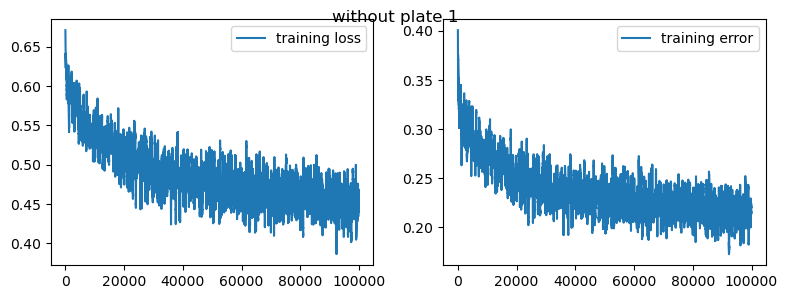

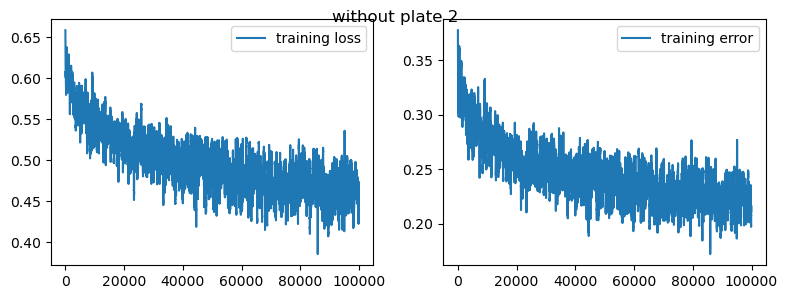

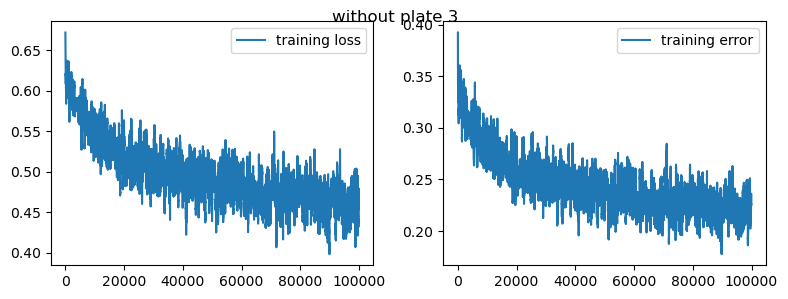

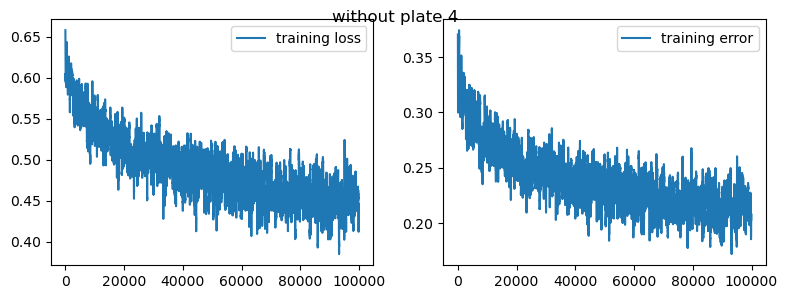

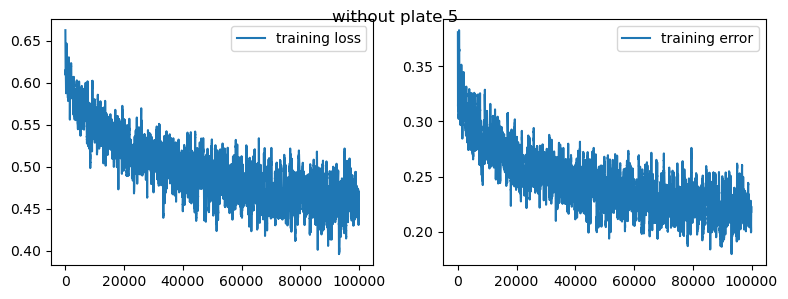

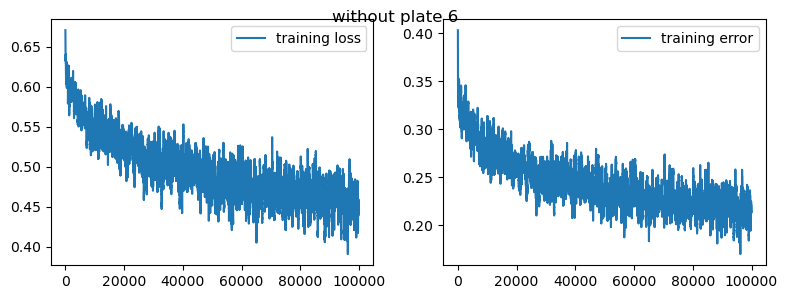

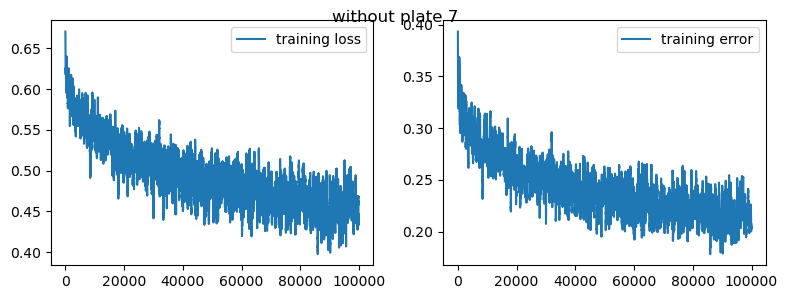

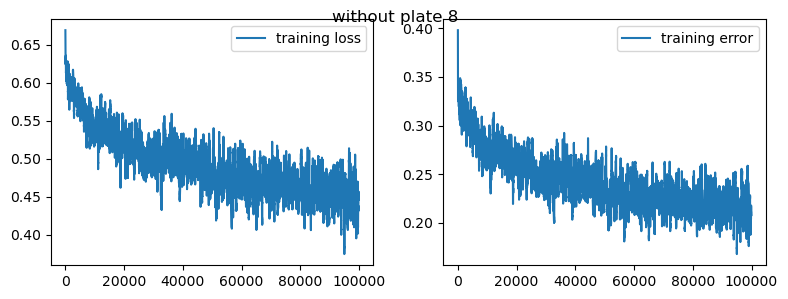

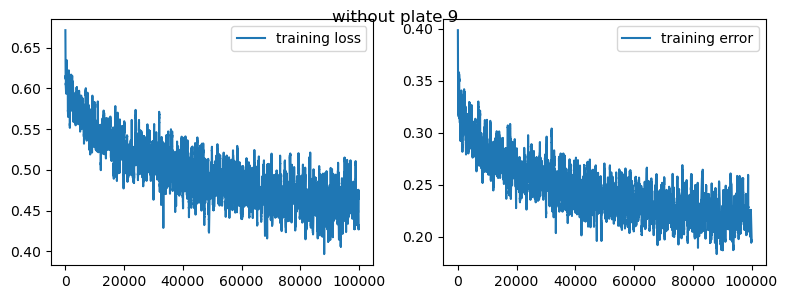

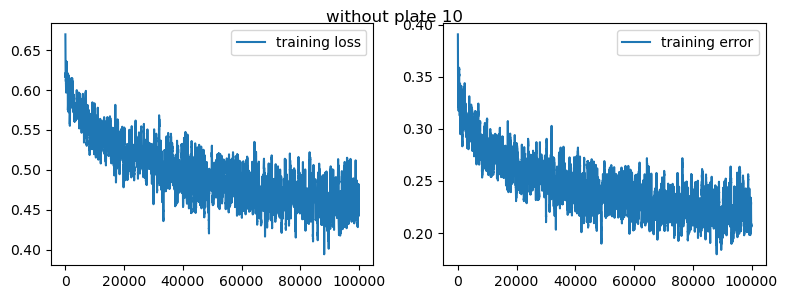

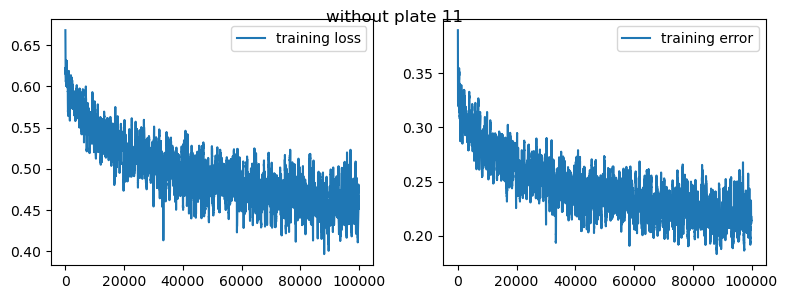

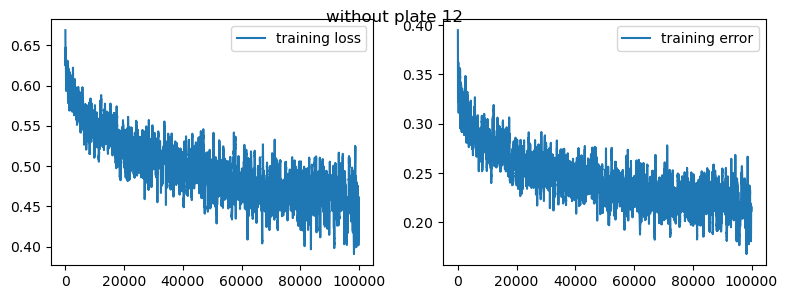

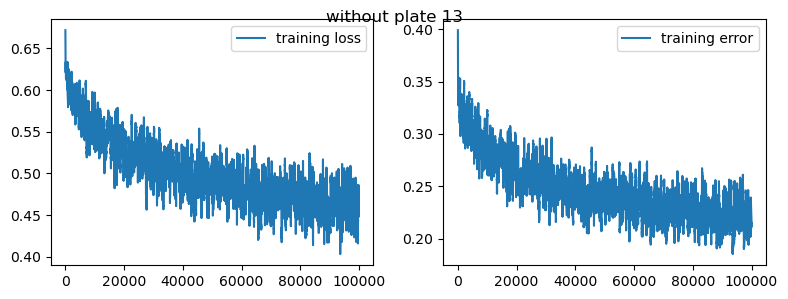

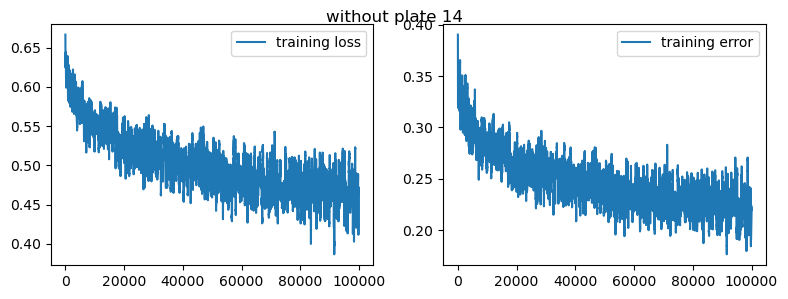

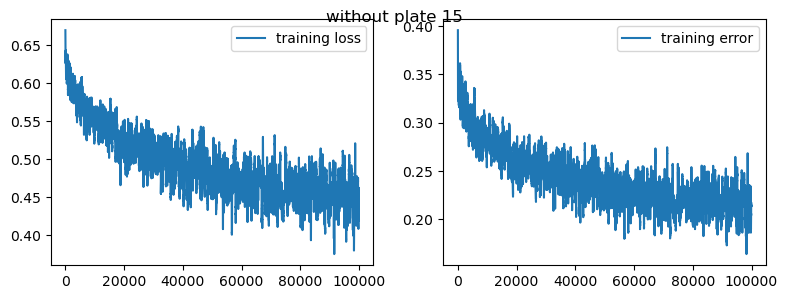

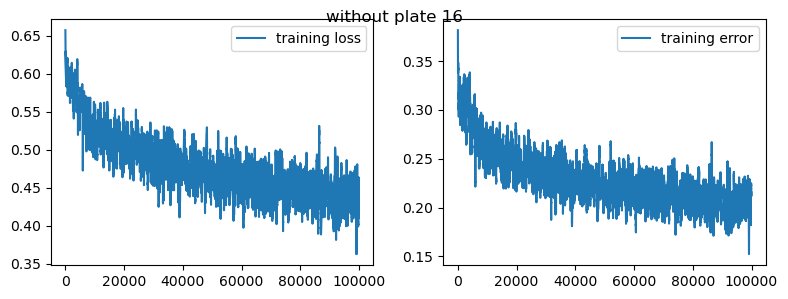

In [ ]:
for plate in use_plates:
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_mil_architecture_relaxed'
    train_loader = healthy_vs_cancer_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = Classifier()
    df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                     save_model=True, seed=12341,
                     transform=T.Compose([T.ColorJitter(brightness=0.2, contrast=0.2), T.RandomHorizontalFlip(), T.RandomVerticalFlip()]))

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

In [ ]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_mil_architecture_relaxed', 
                        test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:19<00:00,  1.22s/it]


lab  pred   i  pat    group  plate
0        1   0.0   0  H01  healthy      1
1        1   0.0   0  H01  healthy      1
2        1   0.0   0  H01  healthy      1
3        1   1.0   0  H01  healthy      1
4        1   0.0   0  H01  healthy      1
...    ...   ...  ..  ...      ...    ...
21195    0   0.0  12  P74   cancer     16
21196    0   0.0  12  P74   cancer     16
21197    0   0.0  12  P74   cancer     16
21198    0   0.0  12  P74   cancer     16
21199    0   0.0  12  P74   cancer     16

[21200 rows x 6 columns]

In [ ]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df

plate  pat    group  pred  counts
0        1  H01  healthy   0.0      52
1        1  H01  healthy   1.0      48
2        1  H02  healthy   1.0      51
3        1  H02  healthy   0.0      49
4        1  H03  healthy   0.0      54
..     ...  ...      ...   ...     ...
405     16  P49   cancer   1.0       2
406     16  P61   cancer   0.0      97
407     16  P61   cancer   1.0       3
408     16  P74   cancer   0.0      97
409     16  P74   cancer   1.0       3

[410 rows x 5 columns]

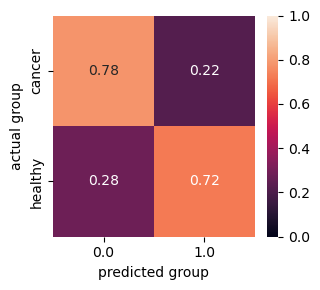

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

In [ ]:
res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()

plate   pat    group  pred
0        1   H01  healthy  0.48
1        1   H02  healthy  0.51
2        1   H03  healthy  0.46
3        1   H04  healthy  0.66
4        1   H05  healthy  0.66
..     ...   ...      ...   ...
207     16  P151   cancer  0.01
208     16   P45   cancer  0.01
209     16   P49   cancer  0.02
210     16   P61   cancer  0.03
211     16   P74   cancer  0.03

[212 rows x 4 columns]

In [ ]:
pat_df = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()
plate_df = pat_df.groupby(['plate', 'group'])['pred'].mean().reset_index()
plate_df.loc[plate_df['group'] != 'healthy', 'group'] = 'C'
plate_df.loc[plate_df['group'] == 'healthy', 'group'] = 'H'
plate_df['group'] = pd.Categorical(values=plate_df['group'], categories=['H', 'C'])
plate_df['H'] = plate_df['pred']
plate_df['C'] = 1 - plate_df['H']

plate_df

plate group      pred         H         C
0       1     C  0.283750  0.283750  0.716250
1       1     H  0.554000  0.554000  0.446000
2       2     C  0.234444  0.234444  0.765556
3       2     H  0.865000  0.865000  0.135000
4       3     C  0.218750  0.218750  0.781250
5       3     H  0.850000  0.850000  0.150000
6       4     C  0.301111  0.301111  0.698889
7       4     H  0.795000  0.795000  0.205000
8       5     C  0.236667  0.236667  0.763333
9       5     H  0.850000  0.850000  0.150000
10      6     C  0.231000  0.231000  0.769000
11      6     H  0.747500  0.747500  0.252500
12      7     C  0.275556  0.275556  0.724444
13      7     H  0.690000  0.690000  0.310000
14      8     C  0.332000  0.332000  0.668000
15      8     H  0.882500  0.882500  0.117500
16      9     C  0.238889  0.238889  0.761111
17      9     H  0.875000  0.875000  0.125000
18     10     C  0.308889  0.308889  0.691111
19     10     H  0.902500  0.902500  0.097500
20     11     C  0.314444  0.314444  0.685556
21     11     H  0.915000  0.915000  0.085000
22     12     C  0.091000  0.091000  0.909000
23     12     H  0.752500  0.752500  0.247500
24     13     C  0.172222  0.172222  0.827778
25     13     H  0.775000  0.775000  0.225000
26     14     C  0.197000  0.197000  0.803000
27     14     H  0.785000  0.785000  0.215000
28     15     C  0.131000  0.131000  0.869000
29     15     H  0.272500  0.272500  0.727500
30     16     C  0.015556  0.015556  0.984444
31     16     H  0.037500  0.037500  0.962500

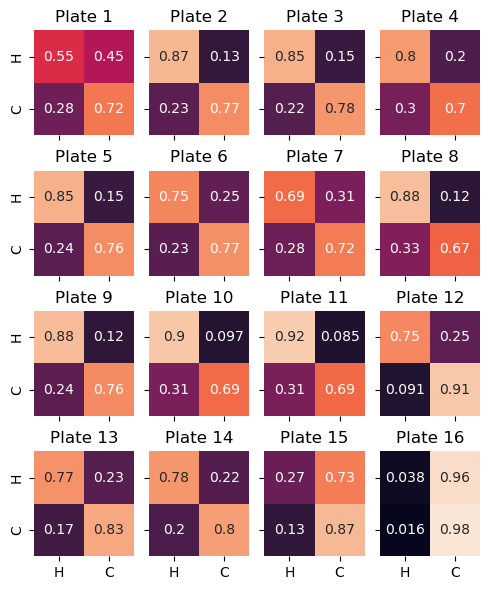

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
for ax, plate in zip(axs.flatten(), use_plates):
    mat = plate_df[plate_df['plate'] == plate].set_index('group').loc[['H', 'C'], ['H', 'C']]
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

In [ ]:
print('done!')

done!
